In [1]:
# Google Driveのマウント
from google.colab import drive, files
drive.mount('/content/drive') # , force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install omegaconf
# !pip install gymnasium
!pip install gymnasium-robotics
# !pip install wandb

  Using cached gymnasium_robotics-1.3.1-py3-none-any.whl.metadata (8.7 kB)
  Using cached mujoco-3.1.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (44 kB)
  Using cached gymnasium-1.0.0-py3-none-any.whl.metadata (9.5 kB)
  Using cached pettingzoo-1.24.3-py3-none-any.whl.metadata (8.5 kB)
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl.metadata (558 bytes)
  Using cached glfw-2.8.0-py2.py27.py3.py30.py31.py32.py33.py34.py35.py36.py37.py38.p39.p310.p311.p312.p313-none-manylinux_2_28_x86_64.whl.metadata (5.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.1/26.1 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 847.8/847.8 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 17.5 MB/s eta 0:00:00


In [3]:
#config.py
from dataclasses import dataclass


@dataclass
class WorldModelConfig:
    emb_dim: int = 1024
    z_dim: int = 32
    num_classes: int = 32
    h_dim: int = 600
    hidden_dim: int = 600
    num_layers_za2hidden: int = 1
    num_layers_h2z: int = 1
    mlp_hidden_dim: int = 400
    min_std: float = 0.1
    kl_balance_alpha: float = 0.8
    kl_loss_scale: float = 0.1


@dataclass
class ExplorerConfig:
    num_emsembles: int = 10
    emsembles_offset: int = 1
    emsembles_target_mode: str = 'z'
    mlp_hidden_dim: int = 400
    min_std: float = 0.1
    discount: float = 0.99
    lambda_: float = 0.95
    actor_entropy_scale: float = 1e-4
    slow_critic_update: int = 100


@dataclass
class AchieverConfig:
    num_positives: int = 256
    neg_sampling_factor: int = 0.1
    mlp_hidden_dim: int = 400
    min_std: float = 0.1
    discount: float = 0.99
    lambda_: float = 0.95
    actor_entropy_scale: float = 1e-4
    slow_critic_update: int = 100


@dataclass
class LEXAModelConfig:
    world_model: WorldModelConfig = WorldModelConfig()
    explorer: ExplorerConfig = ExplorerConfig()
    achiever: AchieverConfig = AchieverConfig()


@dataclass
class DataConfig:
    buffer_size: int = 2e6
    batch_size: int = 50
    seq_length: int = 50
    imagination_horizon: int = 15


@dataclass
class LearningConfig:
    seed_steps: int = 5000
    num_steps: int = 1e7
    expl_episode_freq: int = 2
    world_model_lr: float = 2e-4
    explorer_actor_lr: float = 4e-5
    explorer_critic_lr: float = 1e-4
    achiever_actor_lr: float = 4e-5
    achiever_critic_lr: float = 1e-4
    epsilon: float = 1e-5
    weight_decay: float = 1e-6
    grad_clip: float = 100
    update_freq: int = 4
    eval_episode_freq: int = 5


@dataclass
class EnvConfig:
    task: str = 'FrankaKitchen-v1'
    img_size: int = 128
    action_repeat: int = 2
    time_limit: int = 1000


@dataclass
class WandbConfig:
    logging: bool = False
    name: str = 'lexa'
    group: str = ''
    project: str = 'LEXA'


@dataclass
class Config:
    model: LEXAModelConfig = LEXAModelConfig()
    env: EnvConfig = EnvConfig()
    data: DataConfig = DataConfig()
    learning: LearningConfig = LearningConfig()
    wandb: WandbConfig = WandbConfig()
    device: str = 'cuda'
    seed: int = 0


### model

In [4]:
#model.utils.py

import numpy as np
from PIL import Image
import torch
import torch.distributions as td
from torch.distributions.utils import _standard_normal
from einops import rearrange


class TruncatedNormal(td.Normal):
    def __init__(self, loc: torch.Tensor, scale: torch.Tensor, low: float = -1.0, high: float = 1.0, eps: float = 1e-6) -> None:
        super().__init__(loc, scale, validate_args=False)
        self.low = low
        self.high = high
        self.eps = eps

    def _clamp(self, x: torch.Tensor) -> torch.Tensor:
        clamped_x = torch.clamp(x, self.low + self.eps, self.high - self.eps)
        x = x - x.detach() + clamped_x.detach()
        return x

    def sample(self, clip: float | None = None, sample_shape: torch.Size = torch.Size()) -> torch.Tensor:
        shape = self._extended_shape(sample_shape)
        eps = _standard_normal(shape, dtype=self.loc.dtype, device=self.loc.device)

        eps *= self.scale
        if clip is not None:
            eps = torch.clamp(eps, -clip, clip)
        x = self.loc + eps
        return self._clamp(x)


def compute_lambda_target(rewards: torch.Tensor, discount: float, values: torch.Tensor, lambda_: float):
    V_lambda = torch.zeros_like(rewards)

    for t in reversed(range(rewards.shape[0])):
        if t == rewards.shape[0] - 1:
            V_lambda[t] = rewards[t] + discount * values[t]
        else:
            V_lambda[t] = rewards[t] + discount * ((1-lambda_) * values[t+1] + lambda_ * V_lambda[t+1])

    return V_lambda


In [5]:
#network.py

from typing import Literal
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal, OneHotCategoricalStraightThrough, Independent, Bernoulli

# from .utils import TruncatedNormal


class RSSM(nn.Module):
    def __init__(self,
                 z_dim=30,
                 num_classes=20,
                 h_dim=200,
                 hidden_dim=200,
                 emb_dim=32,
                 action_dim=9,
                 num_layers_za2hidden=1,
                 num_layers_h2z=1,
                 min_std=0.1):
        super(RSSM, self).__init__()

        self.z_dim = z_dim
        self.h_dim = h_dim
        self.hidden_dim = hidden_dim
        self.emb_dim = emb_dim
        self.action_dim = action_dim
        self.num_layers_za2hidden = num_layers_za2hidden
        self.num_layers_h2z = num_layers_h2z
        self.num_classes = num_classes
        self.min_std = min_std

        self.za2hidden = nn.Sequential(
            *([nn.Sequential(nn.Linear(self.z_dim + self.action_dim, self.hidden_dim), nn.ELU())] + \
            [nn.Sequential(nn.Linear(self.hidden_dim, self.hidden_dim), nn.ELU()) for _ in range(self.num_layers_za2hidden - 1)])
        )
        self.transition = nn.GRUCell(self.hidden_dim, self.h_dim)

        self.prior_hidden = nn.Sequential(
            *([nn.Sequential(nn.Linear(self.h_dim, self.hidden_dim), nn.ELU())] + \
            [nn.Sequential(nn.Linear(self.hidden_dim, self.hidden_dim), nn.ELU()) for _ in range(self.num_layers_h2z - 1)])
        )
        self.prior_logits = nn.Linear(self.hidden_dim, self.z_dim * self.num_classes)

        self.posterior_hidden = nn.Sequential(
            *([nn.Sequential(nn.Linear(self.h_dim + self.emb_dim, self.hidden_dim), nn.ELU())] + \
            [nn.Sequential(nn.Linear(self.hidden_dim, self.hidden_dim), nn.ELU()) for _ in range(self.num_layers_h2z - 1)])
        )
        self.posterior_logits = nn.Linear(self.hidden_dim, self.z_dim * self.num_classes)

    def recurrent(self, z, action, h):
        hidden = self.za2hidden(torch.concat([z, action], dim=1))
        next_h = self.transition(hidden, h)
        return next_h

    def prior(self, h, detach=False):
        hidden = self.prior_hidden(h)
        logits = self.prior_logits(hidden)
        logits = logits.reshape(logits.shape[0], self.z_dim, self.num_classes)
        prior = Independent(OneHotCategoricalStraightThrough(logits=logits), 1)
        if detach:
            detach_prior = Independent(OneHotCategoricalStraightThrough(logits=logits.detach()), 1)
            return prior, detach_prior
        return prior

    def posterior(self, h, emb, detach=False):
        hidden = self.posterior_hidden(torch.concat([h, emb], dim=1))
        logits = self.posterior_logits(hidden)
        logits = logits.reshape(logits.shape[0], self.z_dim, self.num_classes)
        posterior = Independent(OneHotCategoricalStraightThrough(logits=logits), 1)
        if detach:
            detach_posterior = Independent(OneHotCategoricalStraightThrough(logits=logits.detach()), 1)
            return posterior, detach_posterior
        return posterior


class ConvEncoder(nn.Module):
    def __init__(self, input_size, emb_dim):
        super(ConvEncoder, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.LayerNorm([32, input_size // 2, input_size // 2]),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.LayerNorm([64, input_size // 4, input_size // 4]),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LayerNorm([128, input_size // 8, input_size // 8]),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.LayerNorm([256, input_size // 16, input_size // 16]),
            nn.ReLU(),
        )

        self.fc = nn.Linear((input_size // 16) ** 2 * 256 , emb_dim)

    def forward(self, x):
        x = self.net(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x


class ConvDecoder(nn.Module):
    def __init__(self, img_size, z_dim, num_classes, h_dim):
        super(ConvDecoder, self).__init__()

        self.img_size = img_size
        self.fc = nn.Sequential(
            nn.Linear(z_dim * num_classes + h_dim, (img_size // 16) ** 2 * 256),
            nn.LayerNorm([(img_size // 16) ** 2 * 256,]),
            nn.ReLU()
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LayerNorm([128, img_size // 8, img_size // 8]),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LayerNorm([64, img_size // 4, img_size // 4]),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LayerNorm([32, img_size // 2, img_size // 2]),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
        )

    def forward(self, z, h):
        x = torch.concat([z, h], dim=1)
        out = self.fc(x)
        out = out.reshape(out.shape[0], 256, self.img_size // 16, self.img_size // 16)
        out = self.net(out)
        dist = Independent(Normal(out, 1), 3)
        return dist


class Discount(nn.Module):
    def __init__(self, z_dim, num_classes, h_dim, hidden_dim=256):
        super(Discount, self).__init__()

        self.z_dim = z_dim
        self.num_classes = num_classes
        self.h_dim = h_dim
        self.hidden_dim = hidden_dim

        self.net = nn.Sequential(
            nn.Linear(z_dim * num_classes + h_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(self.hidden_dim * 2, self.hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, z, h):
        logits = self.net(torch.concat([z, h], dim=1))
        dist = Independent(Bernoulli(logits=logits), 1)
        return dist


class ExprolerStatePredictor(nn.Module):
    def __init__(self, z_dim, num_classes, h_dim, target_dim, min_std, hidden_dim=256):
        super(ExprolerStatePredictor, self).__init__()

        self.z_dim = z_dim
        self.num_classes = num_classes
        self.h_dim = h_dim
        self.min_std = min_std
        self.hidden_dim = hidden_dim
        self.target_dim = target_dim

        self.net = nn.Sequential(
            nn.Linear(z_dim * num_classes + h_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
        )
        self.mean_fc = nn.Linear(hidden_dim, target_dim)
        self.std_fc = nn.Linear(hidden_dim, target_dim)

    def forward(self, z, h):
        h = self.net(torch.concat([z, h], dim=1))
        mean = self.mean_fc(h)
        std = self.std_fc(h) + self.min_std
        return Independent(Normal(mean, std), 1)


class ExplorerActor(nn.Module):
    def __init__(self, action_dim, z_dim, num_classes, h_dim, hidden_dim=256, min_std=0.1):
        super(ExplorerActor, self).__init__()

        self.action_dim = action_dim
        self.z_dim = z_dim
        self.num_classes = num_classes
        self.h_dim = h_dim
        self.hidden_dim = hidden_dim
        self.min_std = min_std

        self.net = nn.Sequential(
            nn.Linear(z_dim * num_classes + h_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
        )
        self.mean_fc = nn.Linear(hidden_dim, action_dim)
        self.std_fc = nn.Linear(hidden_dim, action_dim)

    def forward(self, z, h, train=True):
        h = self.net(torch.concat([z, h], dim=1))
        mean = F.tanh(self.mean_fc(h))
        std = 2 * F.sigmoid(self.std_fc(h) / 2) + self.min_std
        dist = Independent(TruncatedNormal(mean, std, -1, 1), 1)
        if train:
            action = dist.rsample()
            log_prob = dist.log_prob(action.detach())
            entropy = dist.entropy()
            return action, log_prob, entropy
        else:
            action = dist.mean
            return action, None, None


class ExplorerCritic(nn.Module):
    def __init__(self, z_dim, num_classes, h_dim, hidden_dim=256):
        super(ExplorerCritic, self).__init__()

        self.z_dim = z_dim
        self.z_dim = z_dim
        self.num_classes = num_classes
        self.h_dim = h_dim
        self.hidden_dim = hidden_dim

        self.net = nn.Sequential(
            nn.Linear(z_dim * num_classes + h_dim, self.hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, z, h):
        return self.net(torch.concat([z, h]), dim=1)


class State2Emb(nn.Module):
    def __init__(self, z_dim, num_classes, h_dim, emb_dim, hidden_dim=256):
        super(State2Emb, self).__init__()

        self.z_dim = z_dim
        self.num_classes = num_classes
        self.h_dim = h_dim
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim

        self.net = nn.Sequential(
            nn.Linear(z_dim * num_classes + h_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
        )
        self.mean_fc = nn.Linear(hidden_dim, emb_dim)
        self.std_fc = nn.Linear(hidden_dim, emb_dim)

    def forward(self, z, h):
        h = self.net(torch.concat([z, h], dim=1))
        mean = self.mean_fc(h)
        std = self.std_fc(h)
        return Independent(Normal(mean, std), 1)


class AchieverDistanceEstimator(nn.Module):
    def __init__(self, emb_dim, hidden_dim=256):
        super(AchieverDistanceEstimator, self).__init__()

        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim

        self.state2emb = nn

        self.current_fc = nn.Sequential(nn.Linear(emb_dim, hidden_dim),
                                        nn.GELU())
        self.goal_fc = nn.Sequential(nn.Linear(emb_dim, hidden_dim),
                                     nn.GELU())
        self.net = nn.Sequential(
            nn.Linear(self.hidden_dim * 2, self.hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, current_emb, goal_emb):
        cur_h = self.current_fc(current_emb)
        goal_h = self.goal_fc(goal_emb)
        return self.net(torch.concat([cur_h, goal_h]), dim=1)


class AchieverCritic(nn.Module):
    def __init__(self, z_dim, num_classes, h_dim, emb_dim, hidden_dim=256):
        super(AchieverCritic, self).__init__()

        self.z_dim = z_dim
        self.num_classes = num_classes
        self.h_dim = h_dim
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim

        self.state_fc = nn.Sequential(nn.Linear(z_dim * num_classes + h_dim, hidden_dim),
                                      nn.GELU())
        self.goal_fc = nn.Sequential(nn.Linear(emb_dim, hidden_dim),
                                     nn.GELU())
        self.net = nn.Sequential(
            nn.Linear(self.hidden_dim * 2, self.hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, z, h, goal_emb):
        state_h = self.state_fc(torch.concat([z, h]), dim=1)
        goal_h = self.goal_fc(goal_emb)
        return self.net(torch.concat([state_h, goal_h]), dim=1)


class AchieverActor(nn.Module):
    def __init__(self, action_dim, z_dim, num_classes, h_dim, emb_dim, hidden_dim=256, min_std=0.1):
        super(AchieverActor, self).__init__()

        self.action_dim = action_dim
        self.z_dim = z_dim
        self.num_classes = num_classes
        self.h_dim = h_dim
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        self.min_std = min_std

        self.state_fc = nn.Sequential(nn.Linear(z_dim * num_classes + h_dim, hidden_dim),
                                      nn.GELU())
        self.goal_fc = nn.Sequential(nn.Linear(emb_dim, hidden_dim),
                                     nn.GELU())
        self.net = nn.Sequential(
            nn.Linear(self.hidden_dim * 2, self.hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
        )
        self.mean_fc = nn.Linear(hidden_dim, action_dim)
        self.std_fc = nn.Linear(hidden_dim, action_dim)

    def forward(self, z, h, goal_emb, train=True):
        state_h = self.state_fc(torch.concat([z, h], dim=1))
        goal_h = self.goal_fc(goal_emb)
        h = self.net(torch.concat([state_h, goal_h], dim=1))
        mean = F.tanh(self.mean_fc(h))
        std = 2 * F.sigmoid(self.std_fc(h) / 2) + self.min_std
        dist = Independent(TruncatedNormal(mean, std, -1, 1), 1)
        if train:
            action = dist.rsample()
            log_prob = dist.log_prob(action.detach())
            entropy = dist.entropy()
            return action, log_prob, entropy
        else:
            action = dist.mean
        return action, None, None


In [6]:
#worldmodel.py
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import kl_divergence
from einops import rearrange

# from .network import RSSM, ConvEncoder, ConvDecoder, Discount


class WorldModel(nn.Module):
    def __init__(self,
                 img_size,
                 emb_dim,
                 action_dim,
                 z_dim,
                 num_classes,
                 h_dim,
                 hidden_dim,
                 num_layers_za2hidden,
                 num_layers_h2z,
                 mlp_hidden_dim,
                 min_std,
                 kl_balance_alpha,
                 kl_loss_scale,
                 device):
        super(WorldModel, self).__init__()

        self.img_size = img_size
        self.action_dim = action_dim
        self.z_dim = z_dim
        self.num_classes = num_classes
        self.h_dim = h_dim
        self.hidden_dim = hidden_dim
        self.emb_dim = emb_dim
        self.num_layers_za2hidden = num_layers_za2hidden
        self.num_layers_h2z = num_layers_h2z
        self.mlp_hidden_dim = mlp_hidden_dim
        self.min_std = min_std
        self.kl_balance_alpha = kl_balance_alpha
        self.kl_loss_scale = kl_loss_scale
        self.device = device

        self.rssm = RSSM(
            z_dim = z_dim,
            num_classes = num_classes,
            h_dim = h_dim,
            hidden_dim = hidden_dim,
            emb_dim = emb_dim,
            action_dim = action_dim,
            num_layers_za2hidden = num_layers_za2hidden,
            num_layers_h2z = num_layers_h2z,
            min_std = min_std
        )
        self.encoder = ConvEncoder(
            input_size = img_size,
            emb_dim = emb_dim
        )
        self.decoder = ConvDecoder(
            img_size = img_size,
            z_dim = z_dim,
            num_classes = num_classes,
            h_dim = h_dim
        )

    def train(self, observations, actions):
        batch_size, seq_length, *_ = observations.shape
        observations = rearrange(observations, 'b t c h w -> t b c h w')
        actions = rearrange(actions, 'b t d -> t b d')

        embs = self.encoder(rearrange(observations, 't b c h w -> (t b) c h w'))
        embs = rearrange(embs, '(t b) d -> t b d')

        z = torch.zeros(batch_size, self.z_dim*self.num_classes, device=self.device)
        h = torch.zeros(batch_size, self.h_dim, device=self.device)

        zs = torch.empty(seq_length - 1, batch_size, self.z_dim*self.num_classes, device=self.device)
        hs = torch.empty(seq_length - 1, batch_size, self.h_dim, device=self.device)

        kl_loss = 0
        for t in range(seq_length - 1):
            h = self.rssm.recurrent(z, actions[t], h)
            next_prior, detach_next_prior = self.rssm.prior(h, detach=True)
            next_posterior, detach_next_posterior = self.rssm.posterior(h, embs[t+1], detach=True)
            z = next_posterior.rsample().flatten(1)
            hs[t] = h
            zs[t] = z
            kl_loss += self.kl_balance_alpha * torch.mean(kl_divergence(detach_next_posterior, next_prior)) + \
                       (1 - self.kl_balance_alpha) * torch.mean(kl_divergence(next_posterior, detach_next_prior))
        kl_loss = kl_loss / (seq_length - 1)

        flatten_hs = hs.view(-1, self.h_dim)
        flatten_zs = zs.view(-1, self.z_dim * self.num_classes)

        obs_dist = self.decoder(flatten_zs, flatten_hs)

        obs_loss = -torch.mean(obs_dist.log_prob(rearrange(observations[1:], 't b c h w -> (t b) c h w')))

        wm_loss = obs_loss + self.kl_loss_scale * kl_loss
        return wm_loss, (zs, hs), OrderedDict(wm_loss=wm_loss.item(), obs_loss=obs_loss.item(), kl_loss=kl_loss.item())

    def imagine(self, action, z, h):
        next_h = self.rssm.recurrent(z, action, h)
        next_prior = self.rssm.prior(next_h)
        next_z = next_prior.rsample().flatten(1)
        return next_h, next_z


In [7]:
#achiever_reward.py

from typing import Literal
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange

# from .network import AchieverDistanceEstimator, State2Emb


class LatentDistanceReward(nn.Module):
    def __init__(self,
                 z_dim,
                 num_classes,
                 h_dim,
                 emb_dim,
                 mlp_hidden_dim,
                 device):
        super(LatentDistanceReward, self).__init__()

        self.z_dim = z_dim
        self.num_classes = num_classes
        self.h_dim = h_dim
        self.emb_dim = emb_dim
        self.mlp_hidden_dim = mlp_hidden_dim
        self.device = device

        self.state2emb = State2Emb(
            z_dim = z_dim,
            num_classes = num_classes,
            h_dim = h_dim,
            emb_dim = emb_dim,
            hidden_dim = mlp_hidden_dim
        )

        self.distance_estimator = AchieverDistanceEstimator(
            emb_dim = emb_dim,
            hidden_dim = mlp_hidden_dim
        )

    def imagine_compute_reward(self, current_z, current_h, goal_z, goal_h):
        current_emb = self.state2emb(current_z, current_h)
        goal_emb = self.state2emb(goal_z, goal_h)
        distance = self.distance_estimator(current_emb, goal_emb)
        return -distance

    def compute_reward(self, z, h, goal_emb):
        current_emb = self.state2emb(z, h)
        distance = self.distance_estimator(current_emb, goal_emb)
        return -distance

    def train_state2emb(self, zs, hs, target_embs):
        embs_dist = self.state2emb(zs, hs)
        loss = -torch.mean(embs_dist.log_prob(target_embs))
        return loss

    def train_distance_estimator(self, zs, hs, num_positives, neg_sampling_factor, batch_length):
        def get_future_goal_idxs(seq_len, bs):
            cur_idx_list = []
            goal_idx_list = []
            for cur_idx in range(seq_len):
                for goal_idx in range(cur_idx, seq_len):
                    cur_idx_list.append(np.concatenate([np.ones((bs,1), dtype=np.int32)*cur_idx, np.arange(bs).reshape(-1,1)], axis = -1))
                    goal_idx_list.append(np.concatenate([np.ones((bs,1), dtype=np.int32)*goal_idx, np.arange(bs).reshape(-1,1)], axis = -1))

            return np.concatenate(cur_idx_list,0), np.concatenate(goal_idx_list,0)

        def get_future_goal_idxs_neg_sampling(num_negs, seq_len, bs):
            cur_idxs = np.random.randint((0,0), (seq_len, bs), size=(num_negs,2))
            goal_idxs = np.random.randint((0,0), (seq_len, bs), size=(num_negs,2))
            for i in range(num_negs):
                goal_idxs[i,1] = np.random.choice([j for j in range(bs) if j//batch_length != cur_idxs[i,1]//batch_length])
            return cur_idxs, goal_idxs

        zs, hs = zs.detach(), hs.detach()

        current_idxs, goal_idxs = get_future_goal_idxs(zs.shape[0], zs.shape[1])
        idx = np.random.choice(np.arange(len(current_idxs)), num_positives, replace=False)
        current_idx, goal_idx = current_idxs[idx], goal_idxs[idx]
        current_zs, current_hs = zs[current_idx[:,0], current_idx[:,1]], hs[current_idx[:,0], current_idx[:,1]]
        goal_zs, goal_hs = zs[goal_idx[:,0], goal_idx[:,1]], hs[goal_idx[:,0], goal_idx[:,1]]
        current_embs, goal_embs = self.state2emb(current_zs, current_hs).mean, self.state2emb(goal_zs, goal_hs).mean
        target_distance = (goal_idx[:,0] - current_idx[:,0]) / zs.shape[0]
        pred_distance = self.distance_estimator(current_embs, goal_embs)
        loss = F.mse_loss(pred_distance, target_distance)

        num_negatives = num_positives * neg_sampling_factor
        current_idx, goal_idx = get_future_goal_idxs_neg_sampling(num_negatives, zs.shape[0], zs.shape[1])
        current_zs, current_hs = zs[current_idx[:,0], current_idx[:,1]], hs[current_idx[:,0], current_idx[:,1]]
        goal_zs, goal_hs = zs[goal_idx[:,0], goal_idx[:,1]], hs[goal_idx[:,0], goal_idx[:,1]]
        current_embs, goal_embs = self.state2emb(current_zs, current_hs).mean, self.state2emb(goal_zs, goal_hs).mean
        target_distance = torch.ones(num_negatives, 1, device=self.device) * zs.shape[0]
        pred_distance = self.distance_estimator(current_embs, goal_embs)
        loss += F.mse_loss(pred_distance, target_distance)
        return loss


In [8]:
#achiever.py

from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as td
from einops import rearrange

# from .network import AchieverActor, AchieverCritic
# from .worldmodel import WorldModel
# from .achiever_reward import LatentDistanceReward
# from .utils import compute_lambda_target


class Achiever(nn.Module):
    def __init__(self,
                 world_model: WorldModel,
                 instrinsic_reward,
                 action_dim,
                 z_dim,
                 num_classes,
                 h_dim,
                 emb_dim,
                 mlp_hidden_dim,
                 min_std,
                 discount,
                 lambda_,
                 actor_entropy_scale,
                 device):
        super(Achiever, self).__init__()

        self.world_model = world_model

        self.action_dim = action_dim
        self.z_dim = z_dim
        self.num_classes = num_classes
        self.h_dim = h_dim
        self.mlp_hidden_dim = mlp_hidden_dim
        self.discount = discount
        self.lambda_ = lambda_
        self.actor_entropy_scale = actor_entropy_scale
        self.device = device

        self.actor = AchieverActor(
            action_dim = action_dim,
            z_dim = z_dim,
            num_classes = num_classes,
            h_dim = h_dim,
            emb_dim = emb_dim,
            hidden_dim = mlp_hidden_dim,
            min_std = min_std
        )
        self.critic = AchieverCritic(
            z_dim = z_dim,
            num_classes = num_classes,
            h_dim = h_dim,
            emb_dim = emb_dim,
            hidden_dim = mlp_hidden_dim
        )
        self.target_critic = AchieverCritic(
            z_dim = z_dim,
            num_classes = num_classes,
            h_dim = h_dim,
            emb_dim = emb_dim,
            hidden_dim = mlp_hidden_dim
        )
        self.target_critic.load_state_dict(self.critic.state_dict())

        self.instrinsic_reward = instrinsic_reward

    def train(self, init_zs: torch.Tensor, init_hs: torch.Tensor, goal_observations: torch.Tensor, horison_length, num_positives, neg_sampling_factor, batch_seq_length):
        goal_observations = rearrange(goal_observations, 'b t c h w -> (t b) c h w')
        shuffle_idx = torch.randperm(goal_observations.shape[0])
        goal_observations = goal_observations[shuffle_idx]
        goal_embs = self.world_model.encoder(goal_observations)

        zs = init_zs.detach() # (batch_size * seq_length, z_dim * num_classes)
        hs = init_hs.detach() # (batch_size * seq_length, h_dim)

        imagined_zs = torch.empty(horison_length, *init_zs.shape, device=self.device)
        imagined_hs = torch.empty(horison_length, *init_hs.shape, device=self.device)
        imagined_action_log_probs = torch.empty(horison_length, init_zs.shape[0], device=self.device)
        imagined_action_entropys = torch.empty(horison_length, init_zs.shape[0], device=self.device)

        for t in range(horison_length):
            actions, action_log_probs, action_entropys = self.actor(zs.detach(), hs.detach(), goal_embs)

            with torch.no_grad():
                hs, zs = self.world_model.imagine(actions, zs, hs)

            imagined_hs[t] = hs.detach()
            imagined_zs[t] = zs.detach()
            imagined_action_log_probs[t] = action_log_probs
            imagined_action_entropys[t] = action_entropys

        flatten_hs = imagined_hs.view(-1, self.h_dim).detach() # (horison_length * batch_size * seq_length, h_dim)
        flatten_zs = imagined_zs.view(-1, self.z_dim * self.num_classes).detach() # (horison_length * batch_size * seq_length, z_dim * num_classes)

        with torch.no_grad():
            rewards = self.instrinsic_reward.compute_reward(flatten_zs, flatten_hs, goal_embs).view(horison_length, -1) # (horison_length, batch_size * seq_length)
            target_values = self.target_critic(flatten_zs, flatten_hs, goal_embs).view(horison_length, -1) # (horison_length, batch_size * seq_length)

        lambda_target = compute_lambda_target(rewards, self.discount, target_values, self.lambda_)

        objective = imagined_action_log_probs * ((lambda_target - target_values).detach())
        actor_loss = -torch.sum(torch.mean(objective + self.actor_entropy_scale * imagined_action_entropys, dim=1))

        value_mean = self.critic(flatten_zs.detach(), flatten_hs.detach()).view(horison_length, -1)
        value_dist = td.Independent(td.Normal(value_mean, 1),  1)
        critic_loss = -torch.mean(value_dist.log_prob(lambda_target.detach()).unsqueeze(-1))

        distance_estimator_loss = self.instrinsic_reward.train_distance_estimator(imagined_zs, imagined_hs, num_positives, neg_sampling_factor, batch_seq_length)

        return actor_loss, critic_loss, distance_estimator_loss, OrderedDict(ach_actor_loss=actor_loss.item(), ach_critic_loss=critic_loss.item(), distance_estimator_loss=distance_estimator_loss.item())

    def update_critic(self):
        self.target_critic.load_state_dict(self.critic.state_dict())


In [9]:
#explorer_reward.py
from typing import Literal
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange

# from .network import ExprolerStatePredictor


class EmsembleReward(nn.Module):
    def __init__(self,
                 z_dim,
                 num_classes,
                 h_dim,
                 min_std,
                 mlp_hidden_dim,
                 device,
                 num_emsembles = 10,
                 offset = 1,
                 target_mode: Literal['z', 'h', 'zh'] = 'z'):
        super(EmsembleReward, self).__init__()

        self.z_dim = z_dim
        self.num_classes = num_classes
        self.h_dim = h_dim
        self.min_std = min_std
        self.num_emsembles = num_emsembles
        self.offset = offset
        self.target_mode = target_mode
        self.mlp_hidden_dim = mlp_hidden_dim
        self.device = device

        if target_mode == 'z':
            self.target_dim = z_dim * num_classes
        elif target_mode == 'h':
            self.target_dim = h_dim
        elif target_mode == 'zh':
            self.target_dim = z_dim * num_classes + h_dim

        self.emsembles = nn.ModuleList()
        for _ in range(num_emsembles):
            self.emsembles.append(
                ExprolerStatePredictor(
                    z_dim = z_dim,
                    num_classes = num_classes,
                    h_dim = h_dim,
                    min_std = min_std,
                    hidden_dim = mlp_hidden_dim,
                    target_dim = self.target_dim
                )
            )

    def compute_reward(self, z, h):
        input_ = torch.concat([z, h], dim=1)
        preds = torch.empty(self.num_emsembles, z.shape[0], self.target_dim, device=self.device)
        for n in range(self.num_emsembles):
            f = self.emsembles[n]
            preds[n] = f(input_).mean
        var = torch.std(preds, dim=0)
        reward = torch.sum(var, dim=1)
        return reward

    def train(self, zs, hs):
        input_ = torch.concat([zs, hs], dim=2)

        if self.target_mode == 'z':
            target = zs
        elif self.target_mode == 'h':
            target = hs
        elif self.target_mode == 'zh':
            target = input_

        input_ = rearrange(input_[:-self.offset].detach(), 't b d -> (t b) d')
        target = rearrange(input_[self.offset:].detach(), 't b d -> (t b) d')

        loss = 0
        for f in self.emsembles:
            dist = f(input_)
            loss += -torch.mean(dist.log_prob(target))
        return loss, OrderedDict(emsemble_loss=loss.item())



In [10]:
#explorer.py

from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as td
from einops import rearrange

# from .network import ExplorerActor, ExplorerCritic
# from .worldmodel import WorldModel
# from .explorer_reward import EmsembleReward
# from .utils import compute_lambda_target


class Explorer(nn.Module):
    def __init__(self,
                 world_model: WorldModel,
                 instrinsic_reward,
                 action_dim,
                 z_dim,
                 num_classes,
                 h_dim,
                 mlp_hidden_dim,
                 min_std,
                 num_emsembles,
                 emsembles_offset,
                 emsembles_target_mode,
                 discount,
                 lambda_,
                 actor_entropy_scale,
                 device):
        super(Explorer, self).__init__()

        self.world_model = world_model

        self.action_dim = action_dim
        self.z_dim = z_dim
        self.num_classes = num_classes
        self.h_dim = h_dim
        self.mlp_hidden_dim = mlp_hidden_dim
        self.min_std = min_std
        self.num_emsembles = num_emsembles
        self.emsembles_offset = emsembles_offset
        self.emsembles_target_mode = emsembles_target_mode
        self.discount = discount
        self.lambda_ = lambda_
        self.actor_entropy_scale = actor_entropy_scale
        self.device = device

        self.actor = ExplorerActor(
            action_dim = action_dim,
            z_dim = z_dim,
            num_classes = num_classes,
            h_dim = h_dim,
            hidden_dim = mlp_hidden_dim,
            min_std = min_std
        )
        self.critic = ExplorerCritic(
            z_dim = z_dim,
            num_classes = num_classes,
            h_dim = h_dim,
            hidden_dim = mlp_hidden_dim
        )
        self.target_critic = ExplorerCritic(
            z_dim = z_dim,
            num_classes = num_classes,
            h_dim = h_dim,
            hidden_dim = mlp_hidden_dim
        )
        self.target_critic.load_state_dict(self.critic.state_dict())

        self.instrinsic_reward = instrinsic_reward

    def train(self, init_zs: torch.Tensor, init_hs: torch.Tensor, horison_length):
        zs = init_zs.detach() # (batch_size * seq_length, z_dim * num_classes)
        hs = init_hs.detach() # (batch_size * seq_length, h_dim)

        imagined_zs = torch.empty(horison_length, *init_zs.shape, device=self.device)
        imagined_hs = torch.empty(horison_length, *init_hs.shape, device=self.device)
        imagined_action_log_probs = torch.empty(horison_length, init_zs.shape[0], device=self.device)
        imagined_action_entropys = torch.empty(horison_length, init_zs.shape[0], device=self.device)

        for t in range(horison_length):
            actions, action_log_probs, action_entropys = self.actor(zs.detach(), hs.detach())

            with torch.no_grad():
                hs, zs = self.world_model.imagine(actions, zs, hs)

            imagined_hs[t] = hs.detach()
            imagined_zs[t] = zs.detach()
            imagined_action_log_probs[t] = action_log_probs
            imagined_action_entropys[t] = action_entropys

        flatten_hs = imagined_hs.view(-1, self.h_dim).detach() # (horison_length * batch_size * seq_length, h_dim)
        flatten_zs = imagined_zs.view(-1, self.z_dim * self.num_classes).detach() # (horison_length * batch_size * seq_length, z_dim * num_classes)

        with torch.no_grad():
            rewards = self.instrinsic_reward.compute_reward(flatten_zs, flatten_hs).view(horison_length, -1) # (horison_length, batch_size * seq_length)
            target_values = self.target_critic(flatten_zs, flatten_hs).view(horison_length, -1) # (horison_length, batch_size * seq_length)

        lambda_target = compute_lambda_target(rewards, self.discount, target_values, self.lambda_)

        objective = imagined_action_log_probs * ((lambda_target - target_values).detach())
        actor_loss = -torch.sum(torch.mean(objective + self.actor_entropy_scale * imagined_action_entropys, dim=1))

        value_mean = self.critic(flatten_zs.detach(), flatten_hs.detach()).view(horison_length, -1)
        value_dist = td.Independent(td.Normal(value_mean, 1),  1)
        critic_loss = -torch.mean(value_dist.log_prob(lambda_target.detach()).unsqueeze(-1))

        return actor_loss, critic_loss, OrderedDict(exp_actor_loss=actor_loss.item(), exp_critic_loss=critic_loss.item())

    def update_critic(self):
        self.target_critic.load_state_dict(self.critic.state_dict())


In [11]:
#replay_buffer.py
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn


# class ReplayBuffer:
#     def __init__(self,
#                  capacity,
#                  observation_shape,
#                  action_dim):
#         self.capacity = capacity
#         self.observation_shape = observation_shape
#         self.action_dim = action_dim

#         self.observations = np.zeros((capacity, *observation_shape), dtype=np.float32)
#         self.actions = np.zeros((capacity, action_dim), dtype=np.float32)
#         self.done = np.zeros((capacity, 1), dtype=bool)

#         self.idx = 0
#         self.if_filled = False

#     def push(self, observation, action, done):
#         self.observations[self.idx] = observation
#         self.actions[self.idx] = action
#         self.done[self.idx] = done

#         if self.idx == self.capacity - 1:
#             self.is_filled = True
#         self.idx = (self.idx + 1) % self.capacity

#     def sample(self, batch_size, seq_length):
#         episode_borders = np.where(self.done)[0]
#         sampled_indexes = []
#         for _ in range(batch_size):
#             cross_border = True
#             while cross_border:
#                 initial_index = np.random.randint(len(self) - seq_length + 1)
#                 final_index = initial_index + seq_length - 1
#                 cross_border = np.logical_and(initial_index <= episode_borders,
#                                               episode_borders < final_index).any()
#             sampled_indexes += list(range(initial_index, final_index + 1))

#         sampled_observations = self.observations[sampled_indexes].reshape(
#             batch_size, seq_length, *self.observations.shape[1:])
#         sampled_actions = self.actions[sampled_indexes].reshape(
#             batch_size, seq_length, self.actions.shape[1])
#         sampled_done = self.done[sampled_indexes].reshape(
#             batch_size, seq_length, 1)
#         return sampled_observations, sampled_actions, sampled_done

#     def __len__(self):
#         return self.capacity if self.is_filled else self.idx

#     def save(self, dir):
#         dir = Path(dir)
#         np.save(dir / "observations", self.observations)
#         np.save(dir / "actions", self.actions)
#         np.save(dir / "done", self.done)

#     def load(self, dir):
#         dir = Path(dir)
#         self.observations = np.load(dir / "observations")
#         self.actions = np.load(dir / "actions")
#         self.done = np.load(dir / "done")


from pathlib import Path
import numpy as np
import torch


class ReplayBuffer:
    def __init__(self,
                 capacity,
                 observation_shape,
                 action_dim):
        self.capacity = capacity
        self.observation_shape = observation_shape
        self.action_dim = action_dim

        self.observations = np.zeros((capacity, *observation_shape), dtype=np.float32)
        self.actions = np.zeros((capacity, action_dim), dtype=np.float32)
        self.done = np.zeros((capacity, 1), dtype=bool)

        self.idx = 0
        self.if_filled = False  # 修正: 正しいフィールド名を使用

    def push(self, observation, action, done):
        self.observations[self.idx] = observation
        self.actions[self.idx] = action
        self.done[self.idx] = done

        # インデックス更新とバッファが満杯になったかのフラグ更新
        if self.idx == self.capacity - 1:
            self.if_filled = True
        self.idx = (self.idx + 1) % self.capacity

    def sample(self, batch_size, seq_length):
        episode_borders = np.where(self.done)[0]
        sampled_indexes = []
        for _ in range(batch_size):
            cross_border = True
            while cross_border:
                initial_index = np.random.randint(len(self) - seq_length + 1)
                final_index = initial_index + seq_length - 1
                cross_border = np.logical_and(initial_index <= episode_borders,
                                              episode_borders < final_index).any()
            sampled_indexes += list(range(initial_index, final_index + 1))

        sampled_observations = self.observations[sampled_indexes].reshape(
            batch_size, seq_length, *self.observations.shape[1:])
        sampled_actions = self.actions[sampled_indexes].reshape(
            batch_size, seq_length, self.actions.shape[1])
        sampled_done = self.done[sampled_indexes].reshape(
            batch_size, seq_length, 1)
        return sampled_observations, sampled_actions, sampled_done

    def __len__(self):
        return self.capacity if self.if_filled else self.idx  # 修正: 正しいフィールドを使用

    def save(self, dir):
        dir = Path(dir)
        np.save(dir / "observations", self.observations)
        np.save(dir / "actions", self.actions)
        np.save(dir / "done", self.done)

    def load(self, dir):
        dir = Path(dir)
        self.observations = np.load(dir / "observations.npy")
        self.actions = np.load(dir / "actions.npy")
        self.done = np.load(dir / "done.npy")

    def debug_info(self, n=5):
        """
        リプレイバッファのデバッグ情報を取得します。
        :param n: 表示するサンプル数
        :return: デバッグ情報の辞書
        """
        return {
            'current_size': len(self),
            'latest_observations': self.observations[max(0, self.idx - n):self.idx].tolist(),
            'latest_actions': self.actions[max(0, self.idx - n):self.idx].tolist(),
            'latest_done_flags': self.done[max(0, self.idx - n):self.idx].tolist()
        }



In [12]:
#lexa.py

from typing import Union, Literal
import functools
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
from gymnasium import Env

# from config import Config
# from model.worldmodel import WorldModel
# from model.explorer import Explorer
# from model.explorer_reward import EmsembleReward
# from model.achiever import Achiever
# from model.achiever_reward import LatentDistanceReward
# from replay_buffer import ReplayBuffer


class LEXA:
    def __init__(self, cfg: Config, env: Env):
        self.cfg = cfg
        self.env = env
        self.device = torch.device(self.cfg.device)

        self.world_model = WorldModel(
            img_size = cfg.env.img_size,
            emb_dim = cfg.model.world_model.emb_dim,
            action_dim = self.env.action_space.shape[0],
            z_dim = cfg.model.world_model.z_dim,
            num_classes = cfg.model.world_model.num_classes,
            h_dim = cfg.model.world_model.h_dim,
            hidden_dim = cfg.model.world_model.hidden_dim,
            num_layers_za2hidden = cfg.model.world_model.num_layers_za2hidden,
            num_layers_h2z = cfg.model.world_model.num_layers_h2z,
            mlp_hidden_dim = cfg.model.world_model.mlp_hidden_dim,
            min_std = cfg.model.world_model.min_std,
            kl_balance_alpha = cfg.model.world_model.kl_balance_alpha,
            kl_loss_scale = cfg.model.world_model.kl_loss_scale,
            device = self.device
        ).to(self.device)
        self.explorer_reward = EmsembleReward(
            z_dim = cfg.model.world_model.z_dim,
            num_classes = cfg.model.world_model.num_classes,
            h_dim = cfg.model.world_model.h_dim,
            min_std = cfg.model.world_model.min_std,
            mlp_hidden_dim = cfg.model.explorer.mlp_hidden_dim,
            device = self.device,
            num_emsembles = cfg.model.explorer.num_emsembles,
            offset = cfg.model.explorer.emsembles_offset,
            target_mode = cfg.model.explorer.emsembles_target_mode,
        ).to(self.device)
        self.explorer = Explorer(
            world_model = self.world_model,
            instrinsic_reward = self.explorer_reward,
            action_dim = self.env.action_space.shape[0],
            z_dim = cfg.model.world_model.z_dim,
            num_classes = cfg.model.world_model.num_classes,
            h_dim = cfg.model.world_model.h_dim,
            mlp_hidden_dim = cfg.model.explorer.mlp_hidden_dim,
            min_std = cfg.model.explorer.min_std,
            num_emsembles = cfg.model.explorer.num_emsembles,
            emsembles_offset = cfg.model.explorer.emsembles_offset,
            emsembles_target_mode = cfg.model.explorer.emsembles_target_mode,
            discount = cfg.model.explorer.discount,
            lambda_ = cfg.model.explorer.lambda_,
            actor_entropy_scale = cfg.model.explorer.actor_entropy_scale,
            device = self.device
        ).to(self.device)
        self.achiever_reward = LatentDistanceReward(
            z_dim = cfg.model.world_model.z_dim,
            num_classes = cfg.model.world_model.num_classes,
            h_dim = cfg.model.world_model.h_dim,
            emb_dim = cfg.model.world_model.emb_dim,
            mlp_hidden_dim = cfg.model.achiever.mlp_hidden_dim,
            device = self.device
        ).to(self.device)
        self.achiever = Achiever(
            world_model = self.world_model,
            instrinsic_reward = self.achiever_reward,
            action_dim = self.env.action_space.shape[0],
            z_dim = cfg.model.world_model.z_dim,
            num_classes = cfg.model.world_model.num_classes,
            h_dim = cfg.model.world_model.h_dim,
            emb_dim = cfg.model.world_model.emb_dim,
            mlp_hidden_dim = cfg.model.achiever.mlp_hidden_dim,
            min_std = cfg.model.achiever.min_std,
            discount = cfg.model.achiever.discount,
            lambda_ = cfg.model.achiever.lambda_,
            actor_entropy_scale = cfg.model.achiever.actor_entropy_scale,
            device = self.device
        ).to(self.device)

        self.wm_opt = optim.Adam(self.world_model.parameters(),
                                 lr = cfg.learning.world_model_lr,
                                 eps = cfg.learning.epsilon,
                                 weight_decay = cfg.learning.weight_decay)
        self.exp_reward_opt = optim.Adam(self.explorer_reward.parameters(),
                                         lr = cfg.learning.world_model_lr,
                                         eps = cfg.learning.epsilon,
                                         weight_decay = cfg.learning.weight_decay)
        self.exp_actor_opt = optim.Adam(self.explorer.actor.parameters(),
                                        lr = cfg.learning.explorer_actor_lr,
                                        eps = cfg.learning.epsilon,
                                        weight_decay = cfg.learning.weight_decay)
        self.exp_critic_opt = optim.Adam(self.explorer.critic.parameters(),
                                         lr = cfg.learning.explorer_critic_lr,
                                         eps = cfg.learning.epsilon,
                                         weight_decay = cfg.learning.weight_decay)
        self.ach_reward_opt = optim.Adam(self.achiever_reward.parameters(),
                                        lr = cfg.learning.achiever_critic_lr,
                                        eps = cfg.learning.epsilon,
                                        weight_decay = cfg.learning.weight_decay)
        self.ach_actor_opt = optim.Adam(self.achiever.actor.parameters(),
                                        lr = cfg.learning.achiever_actor_lr,
                                        eps = cfg.learning.epsilon,
                                        weight_decay = cfg.learning.weight_decay)
        self.ach_critic_opt = optim.Adam(self.achiever.critic.parameters(),
                                         lr = cfg.learning.achiever_critic_lr,
                                         eps = cfg.learning.epsilon,
                                         weight_decay = cfg.learning.weight_decay)

        self.agent = Agent(self.world_model, self.explorer, self.achiever, self.device)

    def train(self, observations, actions):
        observations = torch.from_numpy(observations).to(self.device)
        actions = torch.from_numpy(actions).to(self.device)

        wm_loss, (zs, hs), wm_metrics = self.world_model.train(observations, actions)
        emsemble_loss, emsemble_metrics = self.explorer_reward.train(zs, hs)
        self.wm_opt.zero_grad(True)
        wm_loss.backward()
        clip_grad_norm_(self.world_model.parameters(), self.cfg.learning.grad_clip)
        self.wm_opt.step()
        self.exp_reward_opt.zero_grad(True)
        emsemble_loss.backward()
        clip_grad_norm_(self.explorer_reward.parameters(), self.cfg.learning.grad_clip)
        self.exp_reward_opt.step()

        zs = zs.view(-1, self.cfg.model.world_model.z_dim * self.cfg.model.world_model.num_classes)
        hs = hs.view(-1, self.cfg.model.world_model.h_dim)

        exp_actor_loss, axp_critic_loss, exp_metrics = self.explorer.train(zs, hs, self.cfg.data.imagination_horizon)
        self.exp_actor_opt.zero_grad(True)
        exp_actor_loss.backward()
        clip_grad_norm_(self.explorer.actor.parameters(), self.cfg.learning.grad_clip)
        self.exp_actor_opt.step()
        self.exp_critic_opt.zero_grad(True)
        axp_critic_loss.backward()
        clip_grad_norm_(self.explorer.critic.parameters(), self.cfg.learning.grad_clip)
        self.exp_critic_opt.step()

        ach_actor_loss, ach_critic_loss, de_loss, ach_metrics = self.achiever.train(zs, hs, observations,
                                                                                    self.cfg.data.imagination_horizon,
                                                                                    self.cfg.model.achiever.num_positives,
                                                                                    self.cfg.model.achiever.neg_sampling_factor,
                                                                                    self.cfg.data.seq_length)
        self.ach_actor_opt.zero_grad(True)
        ach_actor_loss.backward()
        clip_grad_norm_(self.achiever.actor.parameters(), self.cfg.learning.grad_clip)
        self.ach_actor_opt.step()
        self.ach_critic_opt.zero_grad(True)
        ach_critic_loss.backward()
        clip_grad_norm_(self.achiever.critic.parameters(), self.cfg.learning.grad_clip)
        self.ach_critic_opt.step()
        self.ach_reward_opt.zero_grad(True)
        de_loss.backward()
        clip_grad_norm_(self.achiever_reward.parameters(), self.cfg.learning.grad_clip)
        self.ach_reward_opt.step()

        return wm_metrics | emsemble_metrics | exp_metrics | ach_metrics

    @staticmethod
    def load(checkpoint):
        cfg = checkpoint['config']
        env = checkpoint['env']
        output = LEXA(cfg, env)
        output.world_model.load_state_dict(checkpoint['world_model'])
        output.explorer_reward.load_state_dict(checkpoint['exp_reward'])
        output.explorer.load_state_dict(checkpoint['explorer'])
        output.achiever_reward.load_state_dict(checkpoint['ach_reward'])
        output.achiever.load_state_dict(checkpoint['achiever'])
        output.wm_opt.load_state_dict(checkpoint['wm_opt'])
        output.exp_reward_opt.load_state_dict(checkpoint['exp_reward_opt'])
        output.exp_actor_opt.load_state_dict(checkpoint['exp_actor_opt'])
        output.exp_critic_opt.load_state_dict(checkpoint['exp_critic_opt'])
        output.ach_reward_opt.load_state_dict(checkpoint['ach_reward_opt'])
        output.ach_actor_opt.load_state_dict(checkpoint['ach_actor_opt'])
        output.ach_critic_opt.load_state_dict(checkpoint['ach_critic_opt'])
        return output

    def save(self, path):
        path = Path(path)
        path.mkdir(parents=True, exist_ok=True)
        torch.save(
            {
                'world_model': self.world_model.state_dict(),
                'exp_reward': self.explorer_reward.state_dict(),
                'explorer': self.explorer.state_dict(),
                'ach_reward': self.achiever_reward.state_dict(),
                'achiever': self.achiever.state_dict(),
                'wm_opt': self.wm_opt.state_dict(),
                'exp_reward_opt': self.exp_reward_opt.state_dict(),
                'exp_actor_opt': self.exp_actor_opt.state_dict(),
                'exp_critic_opt': self.exp_critic_opt.state_dict(),
                'ach_reward_opt': self.ach_reward_opt.state_dict(),
                'ach_actor_opt': self.ach_actor_opt.state_dict(),
                'ach_critic_opt': self.ach_critic_opt.state_dict(),
                'config': self.cfg,
                'env': self.env,
            },
            path
        )


class Agent:
    def __init__(self, world_model: WorldModel, explorer: Explorer, achiever: Achiever, device: torch.device):
        self.world_model = world_model
        self.explorer = explorer
        self.achiever = achiever
        self.device = device

        self.h = torch.zeros(1, self.world_model.h_dim, device=self.device)

    @torch.no_grad()
    def __call__(self, observation, mode: Literal['explorer', 'achiever'], goal=None, train=True):
        observation = torch.from_numpy(observation).unsqueeze(0).to(self.device)

        if mode == 'explorer':
            policy = self.explorer.actor
        elif mode == 'achiever':
            policy = self.achiever.actor
            assert goal is not None, 'goal must be provided in achiever mode'
            goal = torch.from_numpy(goal).to(self.device)
            goal_emb = self.world_model.encoder(goal)
            policy = functools.partial(policy, goal_emb=goal_emb)

        obs_emb = self.world_model.encoder(observation)
        z_posterior = self.world_model.rssm.posterior(self.h, obs_emb)
        z = z_posterior.sample().flatten(1)
        action, _, _ = policy(z, self.h, train=train)

        self.h = self.world_model.rssm.recurrent(z, action, self.h)

        return action.squeeze().cpu().numpy()

    def reset(self):
        self.h = torch.zeros(1, self.world_model.h_dim, device=self.device)


In [13]:
#utils.py

import random
import torch
import numpy as np
from PIL import Image
from einops import rearrange


def preprocess_obs(obs):
    height, width = obs.shape[0], obs.shape[1]
    obs = Image.fromarray(obs)
    obs = obs.convert("RGB")
    obs = np.array(obs).reshape(height, width, 3)
    obs = obs.astype(np.float32)
    obs = rearrange(obs, 'h w c -> c h w')
    normalized_obs = obs / 255.0 - 0.5
    return normalized_obs


def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [14]:
!sudo apt install -y xvfb
!pip install pyvirtualdisplay
# 仮想ディスプレイのセットアップ
from pyvirtualdisplay import Display

display = Display(visible=0, size=(1024, 768))
display.start()

# 必要なライブラリのインポート
import mujoco
import glfw



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 49 not upgraded.
Need to get 7,815 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.1.0-1build3 [71.8 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 x11-xkb-utils amd64 7.7+5build4 [172 kB]
Get:5 http://archiv

In [ ]:
# import cv2
# import matplotlib.pyplot as plt

# def preprocess_obs(obs, target_size=(128, 128)):
#     """
#     観測データを指定された形状にリサイズします。
#     :param obs: 入力観測データ (H, W, C) または (C, H, W)
#     :param target_size: リサイズ先の形状 (W, H)
#     :return: リサイズされた観測データ
#     """
#     if obs.shape[0] == 3:  # チャネルが先頭にある場合 (C, H, W)
#         obs = np.transpose(obs, (1, 2, 0))  # (H, W, C) に変換

#     resized = cv2.resize(obs, target_size, interpolation=cv2.INTER_AREA)
#     resized = np.transpose(resized, (2, 0, 1))  # (C, H, W) に戻す
#     return resized.astype(np.float32) / 255.0 - 0.5


In [ ]:
#envs.franka_kitchen
from itertools import combinations
import numpy as np
from gymnasium import Env
from gymnasium.spaces import Box
from gymnasium.wrappers import AddRenderObservation, TimeLimit
from gymnasium_robotics.envs.franka_kitchen.kitchen_env import KitchenEnv


class FrankaKichenEnv(Env):
    def __init__(self,
                 img_size,
                 action_repeat,
                 time_limit,
                 seed):
        self._seed = seed
        self._action_repeat = action_repeat
        self._base_env = KitchenEnv(render_mode='rgb_array',
                                    width=img_size,
                                    height=img_size,
                                    default_camera_config=dict(distance=1.86, lookat=[-0.3, .5, 2.], azimuth=90, elevation=-60))
        self._env = TimeLimit(self._base_env, time_limit)

        self.observation_space = Box(0, 255, (img_size, img_size, 3), dtype=np.uint8)
        self.action_space = self._env.action_space

        self.action_space.seed(seed)
        self.observation_space.seed(seed)

        self.obs_element_goals, self.obs_element_indices, self.goal_configs = get_kitchen_benchmark_goals()
        self.goals = list(range(len(self.obs_element_goals)))
        self.goal_idx = -1

        self._env.reset(seed=self._seed)
        self.init_qpos = self._base_env.data.qpos.copy()
        self.init_qvel = self._base_env.data.qvel.copy()
        self.goal_rendered = False

    def reset(self):
        self._env.reset(seed=self._seed)
        self.goal_rendered = False
        return self._env.render()

    def step(self, action):
        total_reward = 0
        for step in range(self._action_repeat):
            state, reward, terminated, truncated, info = self._env.step(action)
            terminated = self.compute_success()
            done = truncated or terminated
            total_reward += reward
            if done:
                break
        obs = self._env.render()
        return obs, total_reward, done, info

    def render(self):
        return self._env.render()

    def close(self):
        return self._env.close()

    def set_goal_idx(self, idx):
        assert idx in self.goals
        self.goal_idx = idx

    def get_goal_obs(self):
        if self.goal_idx == -1:
            return None

        if self.goal_rendered:
            return self.rendered_goal_obs

        element_indices = self.obs_element_indices[self.goal_idx]
        element_values = self.obs_element_goals[self.goal_idx]

        backup_qpos = self._base_env.data.qpos.copy()
        backup_qvel = self._base_env.data.qvel.copy()

        qpos = self.init_qpos.copy()
        qpos[element_indices] = element_values
        self._base_env.robot_env.set_state(qpos, np.zeros_like(self.init_qvel))

        goal_obs = self._env.render()

        self._base_env.robot_env.set_state(backup_qpos, backup_qvel)

        self.goal_rendered = True
        self.rendered_goal_obs = goal_obs
        return goal_obs

    def compute_success(self):
        if self.goal_idx == -1:
            return False

        qpos = self._base_env.data.qpos.copy()

        element_indices = self.obs_element_indices[self.goal_idx]
        element_values = self.obs_element_goals[self.goal_idx]
        goal_qpos = self.init_qpos.copy()
        goal_qpos[element_indices] = element_values

        per_obj_success = {
            'bottom_burner' : ((qpos[9]<-0.38) and (goal_qpos[9]<-0.38)) or ((qpos[9]>-0.38) and (goal_qpos[9]>-0.38)),
            'top_burner':    ((qpos[13]<-0.38) and (goal_qpos[13]<-0.38)) or ((qpos[13]>-0.38) and (goal_qpos[13]>-0.38)),
            'light_switch':  ((qpos[17]<-0.25) and (goal_qpos[17]<-0.25)) or ((qpos[17]>-0.25) and (goal_qpos[17]>-0.25)),
            'slide_cabinet' :  abs(qpos[19] - goal_qpos[19])<0.1,
            'hinge_cabinet' :  abs(qpos[21] - goal_qpos[21])<0.2,
            'microwave' :      abs(qpos[22] - goal_qpos[22])<0.2,
            'kettle' : np.linalg.norm(qpos[23:25] - goal_qpos[23:25]) < 0.2
        }
        task_objects = self.goal_configs[self.goal_idx]

        success = 1
        for _obj in task_objects:
            success *= per_obj_success[_obj]

        return bool(success)

    def get_kitchen_benchmark_goals():

        object_goal_vals = {'bottom_burner' :  [-0.88, -0.01],
                            'light_switch' :  [ -0.69, -0.05],
                            'slide_cabinet':  [0.37],
                            'hinge_cabinet':   [0., 0.5],
                            'microwave'    :   [-0.5],
                            'kettle'       :   [-0.23, 0.75, 1.62, 0.99, 0., 0., -0.06]}

        object_goal_idxs = {'bottom_burner' :  [9, 10],
                            'light_switch' :  [17, 18],
                            'slide_cabinet':  [19],
                            'hinge_cabinet':  [20, 21],
                            'microwave'    :  [22],
                            'kettle'       :  [23, 24, 25, 26, 27, 28, 29]}

        base_task_names = [ 'bottom_burner', 'light_switch', 'slide_cabinet', 'hinge_cabinet', 'microwave', 'kettle' ]


        goal_configs = []
        #single task
        for i in range(6):
          goal_configs.append( [base_task_names[i]])

        #two tasks
        for i,j  in combinations([1,2,3,5], 2) :
          goal_configs.append( [base_task_names[i], base_task_names[j]] )

        obs_element_goals = [] ; obs_element_indices = []
        for objects in goal_configs:
            _goal = np.concatenate([object_goal_vals[obj] for obj in objects])
            _goal_idxs = np.concatenate([object_goal_idxs[obj] for obj in objects])

            obs_element_goals.append(_goal)
            obs_element_indices.append(_goal_idxs)

        return obs_element_goals, obs_element_indices, goal_configs


    def debug_environment(self):
        """
        環境の属性とプロパティをデバッグ出力します。
        """
        print("Attributes of _base_env:")
        print(dir(self._base_env))

        if hasattr(self._base_env, 'unwrapped'):
            print("\nAttributes of _base_env.unwrapped:")
            print(dir(self._base_env.unwrapped))

        if hasattr(self._base_env.unwrapped, 'model'):
            model = self._base_env.unwrapped.model
            print("\nModel properties:")
            print(dir(model))

        if hasattr(self._base_env.unwrapped, 'data'):
            data = self._base_env.unwrapped.data
            print("\nData properties:")
            print(dir(data))


In [15]:
#gymnasium_robotics.envs.maze.maps

"""A collection of maze map structures for the Gymnasium-Robotics PointMaze environments.

The code is inspired by the D4RL repository hosted on GitHub (https://github.com/Farama-Foundation/D4RL), published in the paper
'D4RL: Datasets for Deep Data-Driven Reinforcement Learning' by Justin Fu, Aviral Kumar, Ofir Nachum, George Tucker, Sergey Levine.

Original Author of the code: Justin Fu

The modifications made involve organizing the code into different files: `maps.py`, `maze_env.py`, `point_env.py`, and `point_maze_env.py`.
As well as adding support for the Gymnasium API.

This project is covered by the Apache 2.0 License.
"""

RESET = R = "r"  # Initial Reset position of the agent
GOAL = G = "g"
COMBINED = C = "c"  # These cells can be selected as goal or reset locations


EMPTY_MAZE = [
    [1, 1, 1, 1, 1],
    [1, 0, 0, 0, 1],
    [1, 1, 1, 0, 1],
    [1, 0, 0, 0, 1],
    [1, 1, 1, 1, 1],
]

OPEN = [
    [1, 1, 1, 1, 1, 1, 1],
    [1, 0, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 1],
]

OPEN_DIVERSE_G = [
    [1, 1, 1, 1, 1, 1, 1],
    [1, R, G, G, G, G, 1],
    [1, G, G, G, G, G, 1],
    [1, G, G, G, G, G, 1],
    [1, 1, 1, 1, 1, 1, 1],
]

OPEN_DIVERSE_GR = [
    [1, 1, 1, 1, 1, 1, 1],
    [1, C, C, C, C, C, 1],
    [1, C, C, C, C, C, 1],
    [1, C, C, C, C, C, 1],
    [1, 1, 1, 1, 1, 1, 1],
]

# Maze specifications for dataset generation
U_MAZE = [
    [1, 1, 1, 1, 1],
    [1, 0, 0, 0, 1],
    [1, 1, 1, 0, 1],
    [1, 0, 0, 0, 1],
    [1, 1, 1, 1, 1],
]

MEDIUM_MAZE = [
    [1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 0, 1, 1, 0, 0, 1],
    [1, 0, 0, 1, 0, 0, 0, 1],
    [1, 1, 0, 0, 0, 1, 1, 1],
    [1, 0, 0, 1, 0, 0, 0, 1],
    [1, 0, 1, 0, 0, 1, 0, 1],
    [1, 0, 0, 0, 1, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1],
]

MEDIUM_MAZE_DIVERSE_G = [
    [1, 1, 1, 1, 1, 1, 1, 1],
    [1, R, 0, 1, 1, 0, 0, 1],
    [1, 0, 0, 1, 0, 0, G, 1],
    [1, 1, 0, 0, 0, 1, 1, 1],
    [1, 0, 0, 1, 0, 0, 0, 1],
    [1, G, 1, 0, 0, 1, 0, 1],
    [1, 0, 0, 0, 1, G, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1],
]

MEDIUM_MAZE_DIVERSE_GR = [
    [1, 1, 1, 1, 1, 1, 1, 1],
    [1, C, 0, 1, 1, 0, 0, 1],
    [1, 0, 0, 1, 0, 0, C, 1],
    [1, 1, 0, 0, 0, 1, 1, 1],
    [1, 0, 0, 1, 0, 0, 0, 1],
    [1, C, 1, 0, 0, 1, 0, 1],
    [1, 0, 0, 0, 1, C, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1],
]

LARGE_MAZE = [
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
    [1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
    [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1],
    [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1],
    [1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1],
    [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
]

LARGE_MAZE_DIVERSE_G = [
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, R, 0, 0, 0, 1, G, 0, 0, 0, 0, 1],
    [1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 0, 0, 0, G, 0, 1, 0, 0, G, 1],
    [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1],
    [1, 0, G, 1, 0, 1, 0, 0, 0, 0, 0, 1],
    [1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1],
    [1, 0, 0, 1, G, 0, G, 1, 0, G, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
]

LARGE_MAZE_DIVERSE_GR = [
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, C, 0, 0, 0, 1, C, 0, 0, 0, 0, 1],
    [1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 0, 0, 0, C, 0, 1, 0, 0, C, 1],
    [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1],
    [1, 0, C, 1, 0, 1, 0, 0, 0, 0, 0, 1],
    [1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1],
    [1, 0, 0, 1, C, 0, C, 1, 0, C, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
]


In [16]:
#core.py

from abc import abstractmethod
from typing import Optional

import gymnasium as gym
from gymnasium import error


class GoalEnv(gym.Env):
    r"""A goal-based environment.

    It functions just as any regular Gymnasium environment but it imposes a required structure on the observation_space. More concretely,
    the observation space is required to contain at least three elements, namely `observation`, `desired_goal`, and `achieved_goal`.
    Here, `desired_goal` specifies the goal that the agent should attempt to achieve. `achieved_goal` is the goal that it currently achieved instead.
    `observation` contains the actual observations of the environment as per usual.

    - :meth:`compute_reward` - Externalizes the reward function by taking the achieved and desired goal, as well as extra information. Returns reward.
    - :meth:`compute_terminated` - Returns boolean termination depending on the achieved and desired goal, as well as extra information.
    - :meth:`compute_truncated` - Returns boolean truncation depending on the achieved and desired goal, as well as extra information.
    """

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        """Reset the environment.

        In addition, check if the observation space is correct by inspecting the `observation`, `achieved_goal`, and `desired_goal` keys.
        """
        super().reset(seed=seed)
        # Enforce that each GoalEnv uses a Goal-compatible observation space.
        if not isinstance(self.observation_space, gym.spaces.Dict):
            raise error.Error(
                "GoalEnv requires an observation space of type gym.spaces.Dict"
            )
        for key in ["observation", "achieved_goal", "desired_goal"]:
            if key not in self.observation_space.spaces:
                raise error.Error(
                    'GoalEnv requires the "{}" key to be part of the observation dictionary.'.format(
                        key
                    )
                )

    @abstractmethod
    def compute_reward(self, achieved_goal, desired_goal, info):
        """Compute the step reward. This externalizes the reward function and makes it dependent on a desired goal and the one that was achieved.

        If you wish to include additional rewards that are independent of the goal, you can include the necessary values
        to derive it in 'info' and compute it accordingly.

        Args:
            achieved_goal (object): the goal that was achieved during execution
            desired_goal (object): the desired goal that we asked the agent to attempt to achieve
            info (dict): an info dictionary with additional information

        Returns:
            float: The reward that corresponds to the provided achieved goal w.r.t. to the desired
            goal. Note that the following should always hold true:

                ob, reward, terminated, truncated, info = env.step()
                assert reward == env.compute_reward(ob['achieved_goal'], ob['desired_goal'], info)
        """
        raise NotImplementedError

    @abstractmethod
    def compute_terminated(self, achieved_goal, desired_goal, info):
        """Compute the step termination. Allows to customize the termination states depending on the desired and the achieved goal.

        If you wish to determine termination states independent of the goal, you can include necessary values to derive it in 'info'
        and compute it accordingly. The envirtonment reaches a termination state when this state leads to an episode ending in an episodic
        task thus breaking .

        More information can be found in: https://farama.org/New-Step-API#theory

        Termination states are

        Args:
            achieved_goal (object): the goal that was achieved during execution
            desired_goal (object): the desired goal that we asked the agent to attempt to achieve
            info (dict): an info dictionary with additional information

        Returns:
            bool: The termination state that corresponds to the provided achieved goal w.r.t. to the desired
            goal. Note that the following should always hold true:

                ob, reward, terminated, truncated, info = env.step()
                assert terminated == env.compute_terminated(ob['achieved_goal'], ob['desired_goal'], info)
        """
        raise NotImplementedError

    @abstractmethod
    def compute_truncated(self, achieved_goal, desired_goal, info):
        """Compute the step truncation. Allows to customize the truncated states depending on the desired and the achieved goal.

        If you wish to determine truncated states independent of the goal, you can include necessary values to derive it in 'info'
        and compute it accordingly. Truncated states are those that are out of the scope of the Markov Decision Process (MDP) such
        as time constraints in a continuing task.

        More information can be found in: https://farama.org/New-Step-API#theory

        Args:
            achieved_goal (object): the goal that was achieved during execution
            desired_goal (object): the desired goal that we asked the agent to attempt to achieve
            info (dict): an info dictionary with additional information

        Returns:
            bool: The truncated state that corresponds to the provided achieved goal w.r.t. to the desired
            goal. Note that the following should always hold true:

                ob, reward, terminated, truncated, info = env.step()
                assert truncated == env.compute_truncated(ob['achieved_goal'], ob['desired_goal'], info)
        """
        raise NotImplementedError


In [17]:
#gymnasium_robotics.envs.maze.maze_v4.py


"""A maze environment with Gymnasium API for the Gymnasium-Robotics PointMaze environments.

The code is inspired by the D4RL repository hosted on GitHub (https://github.com/Farama-Foundation/D4RL), published in the paper
'D4RL: Datasets for Deep Data-Driven Reinforcement Learning' by Justin Fu, Aviral Kumar, Ofir Nachum, George Tucker, Sergey Levine.

Original Author of the code: Justin Fu

The modifications made involve organizing the code into different files: `maps.py`, `maze_env.py`, `point_env.py`, and `point_maze_env.py`.
As well as adding support for the Gymnasium API.

This project is covered by the Apache 2.0 License.
"""

import math
import tempfile
import time
import xml.etree.ElementTree as ET
from os import path
from typing import Dict, List, Optional, Union

import numpy as np

# from gymnasium_robotics.core import GoalEnv
# from gymnasium_robotics.envs.maze.maps import COMBINED, GOAL, RESET, U_MAZE


class Maze:
    r"""This class creates and holds information about the maze in the MuJoCo simulation.

    The accessible attributes are the following:
    - :attr:`maze_map` - The maze discrete data structure.
    - :attr:`maze_size_scaling` - The maze scaling for the continuous coordinates in the MuJoCo simulation.
    - :attr:`maze_height` - The height of the walls in the MuJoCo simulation.
    - :attr:`unique_goal_locations` - All the `(i,j)` possible cell indices for goal locations.
    - :attr:`unique_reset_locations` - All the `(i,j)` possible cell indices for agent initialization locations.
    - :attr:`combined_locations` - All the `(i,j)` possible cell indices for goal and agent initialization locations.
    - :attr:`map_length` - Maximum value of j cell index
    - :attr:`map_width` - Mazimum value of i cell index
    - :attr:`x_map_center` - The x coordinate of the map's center
    - :attr:`y_map_center` - The y coordinate of the map's center

    The Maze class also presents a method to convert from cell indices to `(x,y)` coordinates in the MuJoCo simulation:
    - :meth:`cell_rowcol_to_xy` - Convert from `(i,j)` to `(x,y)`

    ### Version History
    * v4: Refactor compute_terminated into a pure function compute_terminated and a new function update_goal which resets the goal position. Bug fix: missing maze_size_scaling factor added in generate_reset_pos() -- only affects AntMaze.
    * v3: refactor version of the D4RL environment, also create dependency on newest [mujoco python bindings](https://mujoco.readthedocs.io/en/latest/python.html) maintained by the MuJoCo team in Deepmind.
    * v2 & v1: legacy versions in the [D4RL](https://github.com/Farama-Foundation/D4RL).
    """

    def __init__(
        self,
        maze_map: List[List[Union[str, int]]],
        maze_size_scaling: float,
        maze_height: float,
    ):

        self._maze_map = maze_map
        self._maze_size_scaling = maze_size_scaling
        self._maze_height = maze_height

        self._unique_goal_locations = []
        self._unique_reset_locations = []
        self._combined_locations = []

        # Get the center cell Cartesian position of the maze. This will be the origin
        self._map_length = len(maze_map)
        self._map_width = len(maze_map[0])
        self._x_map_center = self.map_width / 2 * maze_size_scaling
        self._y_map_center = self.map_length / 2 * maze_size_scaling

    @property
    def maze_map(self) -> List[List[Union[str, int]]]:
        """Returns the list[list] data structure of the maze."""
        return self._maze_map

    @property
    def maze_size_scaling(self) -> float:
        """Returns the scaling value used to integrate the maze
        encoding in the MuJoCo simulation.
        """
        return self._maze_size_scaling

    @property
    def maze_height(self) -> float:
        """Returns the un-scaled height of the walls in the MuJoCo
        simulation.
        """
        return self._maze_height

    @property
    def unique_goal_locations(self) -> List[np.ndarray]:
        """Returns all the possible goal locations in discrete cell
        coordinates (i,j)
        """
        return self._unique_goal_locations

    @property
    def unique_reset_locations(self) -> List[np.ndarray]:
        """Returns all the possible reset locations for the agent in
        discrete cell coordinates (i,j)
        """
        return self._unique_reset_locations

    @property
    def combined_locations(self) -> List[np.ndarray]:
        """Returns all the possible goal/reset locations in discrete cell
        coordinates (i,j)
        """
        return self._combined_locations

    @property
    def map_length(self) -> int:
        """Returns the length of the maze in number of discrete vertical cells
        or number of rows i.
        """
        return self._map_length

    @property
    def map_width(self) -> int:
        """Returns the width of the maze in number of discrete horizontal cells
        or number of columns j.
        """
        return self._map_width

    @property
    def x_map_center(self) -> float:
        """Returns the x coordinate of the center of the maze in the MuJoCo simulation"""
        return self._x_map_center

    @property
    def y_map_center(self) -> float:
        """Returns the x coordinate of the center of the maze in the MuJoCo simulation"""
        return self._y_map_center

    def cell_rowcol_to_xy(self, rowcol_pos: np.ndarray) -> np.ndarray:
        """Converts a cell index `(i,j)` to x and y coordinates in the MuJoCo simulation"""
        x = (rowcol_pos[1] + 0.5) * self.maze_size_scaling - self.x_map_center
        y = self.y_map_center - (rowcol_pos[0] + 0.5) * self.maze_size_scaling

        return np.array([x, y])

    def cell_xy_to_rowcol(self, xy_pos: np.ndarray) -> np.ndarray:
        """Converts a cell x and y coordinates to `(i,j)`"""
        i = math.floor((self.y_map_center - xy_pos[1]) / self.maze_size_scaling)
        j = math.floor((xy_pos[0] + self.x_map_center) / self.maze_size_scaling)
        return np.array([i, j])

    @classmethod
    def make_maze(
        cls,
        agent_xml_path: str,
        maze_map: list,
        maze_size_scaling: float,
        maze_height: float,
    ):
        """Class method that returns an instance of Maze with a decoded maze information and the temporal
           path to the new MJCF (xml) file for the MuJoCo simulation.

        Args:
            agent_xml_path (str): the goal that was achieved during execution
            maze_map (list[list[str,int]]): the desired goal that we asked the agent to attempt to achieve
            maze_size_scaling (float): an info dictionary with additional information
            maze_height (float): an info dictionary with additional information

        Returns:
            Maze: The reward that corresponds to the provided achieved goal w.r.t. to the desired
            goal. Note that the following should always hold true:
            str: The xml temporal file to the new mjcf model with the included maze.
        """
        tree = ET.parse(agent_xml_path)
        worldbody = tree.find(".//worldbody")

        maze = cls(maze_map, maze_size_scaling, maze_height)
        empty_locations = []
        for i in range(maze.map_length):
            for j in range(maze.map_width):
                struct = maze_map[i][j]
                # Store cell locations in simulation global Cartesian coordinates
                x = (j + 0.5) * maze_size_scaling - maze.x_map_center
                y = maze.y_map_center - (i + 0.5) * maze_size_scaling
                if struct == 1:  # Unmovable block.
                    # Offset all coordinates so that maze is centered.
                    ET.SubElement(
                        worldbody,
                        "geom",
                        name=f"block_{i}_{j}",
                        pos=f"{x} {y} {maze_height / 2 * maze_size_scaling}",
                        size=f"{0.5 * maze_size_scaling} {0.5 * maze_size_scaling} {maze_height / 2 * maze_size_scaling}",
                        type="box",
                        material="",
                        contype="1",
                        conaffinity="1",
                        rgba="0.7 0.5 0.3 1.0",
                    )

                elif struct == RESET:
                    maze._unique_reset_locations.append(np.array([x, y]))
                elif struct == GOAL:
                    maze._unique_goal_locations.append(np.array([x, y]))
                elif struct == COMBINED:
                    maze._combined_locations.append(np.array([x, y]))
                elif struct == 0:
                    empty_locations.append(np.array([x, y]))

        # Add target site for visualization
        ET.SubElement(
            worldbody,
            "site",
            name="target",
            pos=f"0 0 {maze_height / 2 * maze_size_scaling}",
            size=f"{0.2 * maze_size_scaling}",
            rgba="1 0 0 0",
            type="sphere",
        )

        # Add the combined cell locations (goal/reset) to goal and reset
        if (
            not maze._unique_goal_locations
            and not maze._unique_reset_locations
            and not maze._combined_locations
        ):
            # If there are no given "r", "g" or "c" cells in the maze data structure,
            # any empty cell can be a reset or goal location at initialization.
            maze._combined_locations = empty_locations
        elif not maze._unique_reset_locations and not maze._combined_locations:
            # If there are no given "r" or "c" cells in the maze data structure,
            # any empty cell can be a reset location at initialization.
            maze._unique_reset_locations = empty_locations
        elif not maze._unique_goal_locations and not maze._combined_locations:
            # If there are no given "g" or "c" cells in the maze data structure,
            # any empty cell can be a gaol location at initialization.
            maze._unique_goal_locations = empty_locations

        maze._unique_goal_locations += maze._combined_locations
        maze._unique_reset_locations += maze._combined_locations

        # Save new xml with maze to a temporary file
        with tempfile.TemporaryDirectory() as tmp_dir:
            temp_xml_name = f"ant_maze{str(time.time())}.xml"
            temp_xml_path = path.join(path.dirname(tmp_dir), temp_xml_name)
            tree.write(temp_xml_path)

        return maze, temp_xml_path


class MazeEnv(GoalEnv):
    def __init__(
        self,
        agent_xml_path: str,
        reward_type: str = "dense",
        continuing_task: bool = True,
        reset_target: bool = True,
        maze_map: List[List[Union[int, str]]] = U_MAZE,
        maze_size_scaling: float = 1.0,
        maze_height: float = 0.5,
        position_noise_range: float = 0.25,
        **kwargs,
    ):

        self.reward_type = reward_type
        self.continuing_task = continuing_task
        self.reset_target = reset_target
        self.maze, self.tmp_xml_file_path = Maze.make_maze(
            agent_xml_path, maze_map, maze_size_scaling, maze_height
        )

        self.position_noise_range = position_noise_range

    def generate_target_goal(self) -> np.ndarray:
        assert len(self.maze.unique_goal_locations) > 0
        goal_index = self.np_random.integers(
            low=0, high=len(self.maze.unique_goal_locations)
        )
        goal = self.maze.unique_goal_locations[goal_index].copy()
        return goal

    def generate_reset_pos(self) -> np.ndarray:
        assert len(self.maze.unique_reset_locations) > 0

        # While reset position is close to goal position
        reset_pos = self.goal.copy()
        while (
            np.linalg.norm(reset_pos - self.goal) <= 0.5 * self.maze.maze_size_scaling
        ):
            reset_index = self.np_random.integers(
                low=0, high=len(self.maze.unique_reset_locations)
            )
            reset_pos = self.maze.unique_reset_locations[reset_index].copy()

        return reset_pos

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[Dict[str, Optional[np.ndarray]]] = None,
    ):
        """Reset the maze simulation.

        Args:
            options (dict[str, np.ndarray]): the options dictionary can contain two items, "goal_cell" and "reset_cell" that will set the initial goal and reset location (i,j) in the self.maze.map list of list maze structure.

        """
        super().reset(seed=seed)

        if options is None:
            goal = self.generate_target_goal()
            # Add noise to goal position
            self.goal = self.add_xy_position_noise(goal)
            reset_pos = self.generate_reset_pos()
        else:
            if "goal_cell" in options and options["goal_cell"] is not None:
                # assert that goal cell is valid
                assert self.maze.map_length > options["goal_cell"][0]
                assert self.maze.map_width > options["goal_cell"][1]
                assert (
                    self.maze.maze_map[options["goal_cell"][0]][options["goal_cell"][1]]
                    != 1
                ), f"Goal can't be placed in a wall cell, {options['goal_cell']}"

                goal = self.maze.cell_rowcol_to_xy(options["goal_cell"])

            else:
                goal = self.generate_target_goal()

            # Add noise to goal position
            self.goal = self.add_xy_position_noise(goal)

            if "reset_cell" in options and options["reset_cell"] is not None:
                # assert that goal cell is valid
                assert self.maze.map_length > options["reset_cell"][0]
                assert self.maze.map_width > options["reset_cell"][1]
                assert (
                    self.maze.maze_map[options["reset_cell"][0]][
                        options["reset_cell"][1]
                    ]
                    != 1
                ), f"Reset can't be placed in a wall cell, {options['reset_cell']}"

                reset_pos = self.maze.cell_rowcol_to_xy(options["reset_cell"])

            else:
                reset_pos = self.generate_reset_pos()

        # Update the position of the target site for visualization
        self.update_target_site_pos()
        # Add noise to reset position
        self.reset_pos = self.add_xy_position_noise(reset_pos)

        # Update the position of the target site for visualization
        self.update_target_site_pos()

    def add_xy_position_noise(self, xy_pos: np.ndarray) -> np.ndarray:
        """Pass an x,y coordinate and it will return the same coordinate with a noise addition
        sampled from a uniform distribution
        """
        noise_x = (
            self.np_random.uniform(
                low=-self.position_noise_range, high=self.position_noise_range
            )
            * self.maze.maze_size_scaling
        )
        noise_y = (
            self.np_random.uniform(
                low=-self.position_noise_range, high=self.position_noise_range
            )
            * self.maze.maze_size_scaling
        )
        xy_pos[0] += noise_x
        xy_pos[1] += noise_y

        return xy_pos

    def compute_reward(
        self, achieved_goal: np.ndarray, desired_goal: np.ndarray, info
    ) -> float:
        distance = np.linalg.norm(achieved_goal - desired_goal, axis=-1)
        if self.reward_type == "dense":
            return np.exp(-distance)
        elif self.reward_type == "sparse":
            return (distance <= 0.45).astype(np.float64)

    def compute_terminated(
        self, achieved_goal: np.ndarray, desired_goal: np.ndarray, info
    ) -> bool:
        if not self.continuing_task:
            # If task is episodic terminate the episode when the goal is reached
            return bool(np.linalg.norm(achieved_goal - desired_goal) <= 0.45)
        else:
            # Continuing tasks don't terminate, episode will be truncated when time limit is reached (`max_episode_steps`)
            return False

    def update_goal(self, achieved_goal: np.ndarray) -> None:
        """Update goal position if continuing task and within goal radius."""

        if (
            self.continuing_task
            and self.reset_target
            and bool(np.linalg.norm(achieved_goal - self.goal) <= 0.45)
            and len(self.maze.unique_goal_locations) > 1
        ):
            # Generate a goal while within 0.45 of achieved_goal. The distance check above
            # is not redundant, it avoids calling update_target_site_pos() unless necessary
            while np.linalg.norm(achieved_goal - self.goal) <= 0.45:
                # Generate another goal
                goal = self.generate_target_goal()
                # Add noise to goal position
                self.goal = self.add_xy_position_noise(goal)

            # Update the position of the target site for visualization
            self.update_target_site_pos()

    def compute_truncated(
        self, achieved_goal: np.ndarray, desired_goal: np.ndarray, info
    ) -> bool:
        return False

    def update_target_site_pos(self, pos):
        """Override this method to update the site qpos in the MuJoCo simulation
        after a new goal is selected. This is mainly for visualization purposes."""
        raise NotImplementedError


In [18]:
#gymnasium_robotics.envs.utils.mujoco_utils.py

from typing import Dict, Tuple, Union

import numpy as np
from gymnasium import error

try:
    import mujoco
    from mujoco import MjData, MjModel, mjtObj
except ImportError as e:
    raise error.DependencyNotInstalled(f"{e}. (HINT: you need to install mujoco")

MJ_OBJ_TYPES = [
    "mjOBJ_BODY",
    "mjOBJ_JOINT",
    "mjOBJ_GEOM",
    "mjOBJ_SITE",
    "mjOBJ_CAMERA",
    "mjOBJ_ACTUATOR",
    "mjOBJ_SENSOR",
]


def robot_get_obs(model, data, joint_names):
    """Returns all joint positions and velocities associated with a robot."""
    if data.qpos is not None and joint_names:
        names = [n for n in joint_names if n.startswith("robot")]
        return (
            np.squeeze(np.array([get_joint_qpos(model, data, name) for name in names])),
            np.squeeze(np.array([get_joint_qvel(model, data, name) for name in names])),
        )
    return np.zeros(0), np.zeros(0)


def ctrl_set_action(model, data, action):
    """For torque actuators it copies the action into mujoco ctrl field.

    For position actuators it sets the target relative to the current qpos.
    """
    if model.nmocap > 0:
        _, action = np.split(action, (model.nmocap * 7,))

    if len(data.ctrl) > 0:
        for i in range(action.shape[0]):
            if model.actuator_biastype[i] == 0:
                data.ctrl[i] = action[i]
            else:
                idx = model.jnt_qposadr[model.actuator_trnid[i, 0]]
                data.ctrl[i] = data.qpos[idx] + action[i]


def mocap_set_action(model, data, action):
    """Update the position of the mocap body with the desired action.

    The action controls the robot using mocaps. Specifically, bodies
    on the robot (for example the gripper wrist) is controlled with
    mocap bodies. In this case the action is the desired difference
    in position and orientation (quaternion), in world coordinates,
    of the target body. The mocap is positioned relative to
    the target body according to the delta, and the MuJoCo equality
    constraint optimizer tries to center the welded body on the mocap.
    """
    if model.nmocap > 0:
        action, _ = np.split(action, (model.nmocap * 7,))
        action = action.reshape(model.nmocap, 7)

        pos_delta = action[:, :3]
        quat_delta = action[:, 3:]

        reset_mocap2body_xpos(model, data)
        data.mocap_pos[:] = data.mocap_pos + pos_delta
        data.mocap_quat[:] = data.mocap_quat + quat_delta


def reset_mocap_welds(model, data):
    """Resets the mocap welds that we use for actuation."""
    if model.nmocap > 0 and model.eq_data is not None:
        for i in range(model.eq_data.shape[0]):
            if model.eq_type[i] == mujoco.mjtEq.mjEQ_WELD:
                model.eq_data[i, :7] = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0])
    mujoco.mj_forward(model, data)


def reset_mocap2body_xpos(model, data):
    """Resets the position and orientation of the mocap bodies to the same
    values as the bodies they're welded to.
    """

    if model.eq_type is None or model.eq_obj1id is None or model.eq_obj2id is None:
        return
    for eq_type, obj1_id, obj2_id in zip(
        model.eq_type, model.eq_obj1id, model.eq_obj2id
    ):
        if eq_type != mujoco.mjtEq.mjEQ_WELD:
            continue

        mocap_id = model.body_mocapid[obj1_id]
        if mocap_id != -1:
            # obj1 is the mocap, obj2 is the welded body
            body_idx = obj2_id
        else:
            # obj2 is the mocap, obj1 is the welded body
            mocap_id = model.body_mocapid[obj2_id]
            body_idx = obj1_id

        assert mocap_id != -1
        data.mocap_pos[mocap_id][:] = data.xpos[body_idx]
        data.mocap_quat[mocap_id][:] = data.xquat[body_idx]


def get_site_jacp(model, data, site_id):
    """Return the Jacobian' translational component of the end-effector of
    the corresponding site id.
    """
    jacp = np.zeros((3, model.nv))
    mujoco.mj_jacSite(model, data, jacp, None, site_id)

    return jacp


def get_site_jacr(model, data, site_id):
    """Return the Jacobian' rotational component of the end-effector of
    the corresponding site id.
    """
    jacr = np.zeros((3, model.nv))
    mujoco.mj_jacSite(model, data, None, jacr, site_id)

    return jacr


def set_joint_qpos(model, data, name, value):
    """Set the joint positions (qpos) of the model."""
    joint_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, name)
    assert joint_id != -1, f"Joint with name '{name}' is not part of the model!"
    joint_type = model.jnt_type[joint_id]
    joint_addr = model.jnt_qposadr[joint_id]

    if joint_type == mujoco.mjtJoint.mjJNT_FREE:
        ndim = 7
    elif joint_type == mujoco.mjtJoint.mjJNT_BALL:
        ndim = 4
    else:
        assert joint_type in (mujoco.mjtJoint.mjJNT_HINGE, mujoco.mjtJoint.mjJNT_SLIDE)
        ndim = 1

    start_idx = joint_addr
    end_idx = joint_addr + ndim
    value = np.array(value)
    if ndim > 1:
        assert value.shape == (
            end_idx - start_idx
        ), f"Value has incorrect shape {name}: {value}"
    data.qpos[start_idx:end_idx] = value


def set_joint_qvel(model, data, name, value):
    """Set the joints linear and angular (qvel) of the model."""
    joint_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, name)
    assert joint_id != -1, f"Joint with name '{name}' is not part of the model!"
    joint_type = model.jnt_type[joint_id]
    joint_addr = model.jnt_dofadr[joint_id]

    if joint_type == mujoco.mjtJoint.mjJNT_FREE:
        ndim = 6
    elif joint_type == mujoco.mjtJoint.mjJNT_BALL:
        ndim = 3
    else:
        assert joint_type in (mujoco.mjtJoint.mjJNT_HINGE, mujoco.mjtJoint.mjJNT_SLIDE)
        ndim = 1

    start_idx = joint_addr
    end_idx = joint_addr + ndim
    value = np.array(value)
    if ndim > 1:
        assert value.shape == (
            end_idx - start_idx
        ), f"Value has incorrect shape {name}: {value}"
    data.qvel[start_idx:end_idx] = value


def get_joint_qpos(model, data, name):
    """Return the joints position and orientation (qpos) of the model."""
    joint_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, name)
    assert joint_id != -1, f"Joint with name '{name}' is not part of the model!"
    joint_type = model.jnt_type[joint_id]
    joint_addr = model.jnt_qposadr[joint_id]

    if joint_type == mujoco.mjtJoint.mjJNT_FREE:
        ndim = 7
    elif joint_type == mujoco.mjtJoint.mjJNT_BALL:
        ndim = 4
    else:
        assert joint_type in (mujoco.mjtJoint.mjJNT_HINGE, mujoco.mjtJoint.mjJNT_SLIDE)
        ndim = 1

    start_idx = joint_addr
    end_idx = joint_addr + ndim

    return data.qpos[start_idx:end_idx].copy()


def get_joint_qvel(model, data, name):
    """Return the joints linear and angular velocities (qvel) of the model."""
    joint_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, name)
    assert joint_id != -1, f"Joint with name '{name}' is not part of the model!"
    joint_type = model.jnt_type[joint_id]
    joint_addr = model.jnt_dofadr[joint_id]

    if joint_type == mujoco.mjtJoint.mjJNT_FREE:
        ndim = 6
    elif joint_type == mujoco.mjtJoint.mjJNT_BALL:
        ndim = 4
    else:
        assert joint_type in (mujoco.mjtJoint.mjJNT_HINGE, mujoco.mjtJoint.mjJNT_SLIDE)
        ndim = 1

    start_idx = joint_addr
    end_idx = joint_addr + ndim

    return data.qvel[start_idx:end_idx].copy()


def get_site_xpos(model, data, name):
    site_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SITE, name)
    assert site_id != -1, f"Site with name '{name}' is not part of the model!"
    return data.site_xpos[site_id]


def get_site_xvelp(model, data, name):
    site_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SITE, name)
    assert site_id != -1, f"Site with name '{name}' is not part of the model!"
    jacp = get_site_jacp(model, data, site_id)
    xvelp = jacp @ data.qvel
    return xvelp


def get_site_xvelr(model, data, name):
    site_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SITE, name)
    assert site_id != -1, f"Site with name '{name}' is not part of the model!"
    jacp = get_site_jacr(model, data, site_id)
    xvelp = jacp @ data.qvel
    return xvelp


def set_mocap_pos(model, data, name, value):
    body_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, name)
    assert body_id != -1, f"Body with name '{name}' is not part of the model!"
    mocap_id = model.body_mocapid[body_id]
    data.mocap_pos[mocap_id] = value


def set_mocap_quat(model: MjModel, data: MjData, name: str, value):
    body_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, name)
    assert body_id != -1, f"Body with name '{name}' is not part of the model!"
    mocap_id = model.body_mocapid[body_id]
    data.mocap_quat[mocap_id] = value


def get_site_xmat(model: MjModel, data: MjData, name: str):
    site_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SITE, name)
    assert site_id != -1, f"Site with name '{name}' is not part of the model!"
    return data.site_xmat[site_id].reshape(3, 3)


def extract_mj_names(
    model: MjModel, obj_type: mjtObj
) -> Tuple[Union[Tuple[str, ...], Tuple[()]], Dict[str, int], Dict[int, str]]:

    if obj_type == mujoco.mjtObj.mjOBJ_BODY:
        name_addr = model.name_bodyadr
        n_obj = model.nbody

    elif obj_type == mujoco.mjtObj.mjOBJ_JOINT:
        name_addr = model.name_jntadr
        n_obj = model.njnt

    elif obj_type == mujoco.mjtObj.mjOBJ_GEOM:
        name_addr = model.name_geomadr
        n_obj = model.ngeom

    elif obj_type == mujoco.mjtObj.mjOBJ_SITE:
        name_addr = model.name_siteadr
        n_obj = model.nsite

    elif obj_type == mujoco.mjtObj.mjOBJ_LIGHT:
        name_addr = model.name_lightadr
        n_obj = model.nlight

    elif obj_type == mujoco.mjtObj.mjOBJ_CAMERA:
        name_addr = model.name_camadr
        n_obj = model.ncam

    elif obj_type == mujoco.mjtObj.mjOBJ_ACTUATOR:
        name_addr = model.name_actuatoradr
        n_obj = model.nu

    elif obj_type == mujoco.mjtObj.mjOBJ_SENSOR:
        name_addr = model.name_sensoradr
        n_obj = model.nsensor

    elif obj_type == mujoco.mjtObj.mjOBJ_TENDON:
        name_addr = model.name_tendonadr
        n_obj = model.ntendon

    elif obj_type == mujoco.mjtObj.mjOBJ_MESH:
        name_addr = model.name_meshadr
        n_obj = model.nmesh
    else:
        raise ValueError(
            "`{}` was passed as the MuJoCo model object type. The MuJoCo model object type can only be of the following mjtObj enum types: {}.".format(
                obj_type, MJ_OBJ_TYPES
            )
        )

    id2name = {i: None for i in range(n_obj)}
    name2id = {}
    for addr in name_addr:
        name = model.names[addr:].split(b"\x00")[0].decode()
        if name:
            obj_id = mujoco.mj_name2id(model, obj_type, name)
            assert 0 <= obj_id < n_obj and id2name[obj_id] is None
            name2id[name] = obj_id
            id2name[obj_id] = name

    return tuple(id2name[id] for id in sorted(name2id.values())), name2id, id2name


class MujocoModelNames:
    """Access mjtObj object names and ids of the current MuJoCo model.

    This class supports access to the names and ids of the following mjObj types:
        mjOBJ_BODY
        mjOBJ_JOINT
        mjOBJ_GEOM
        mjOBJ_SITE
        mjOBJ_CAMERA
        mjOBJ_ACTUATOR
        mjOBJ_SENSOR

    The properties provided for each ``mjObj`` are:
        ``mjObj``_names: list of the mjObj names in the model of type mjOBJ_FOO.
        ``mjObj``_name2id: dictionary with name of the mjObj as keys and id of the mjObj as values.
        ``mjObj``_id2name: dictionary with id of the mjObj as keys and name of the mjObj as values.
    """

    def __init__(self, model: MjModel):
        """Access mjtObj object names and ids of the current MuJoCo model.

        Args:
            model: mjModel of the MuJoCo environment.
        """
        (
            self._body_names,
            self._body_name2id,
            self._body_id2name,
        ) = extract_mj_names(model, mujoco.mjtObj.mjOBJ_BODY)
        (
            self._joint_names,
            self._joint_name2id,
            self._joint_id2name,
        ) = extract_mj_names(model, mujoco.mjtObj.mjOBJ_JOINT)
        (
            self._geom_names,
            self._geom_name2id,
            self._geom_id2name,
        ) = extract_mj_names(model, mujoco.mjtObj.mjOBJ_GEOM)
        (
            self._site_names,
            self._site_name2id,
            self._site_id2name,
        ) = extract_mj_names(model, mujoco.mjtObj.mjOBJ_SITE)
        (
            self._camera_names,
            self._camera_name2id,
            self._camera_id2name,
        ) = extract_mj_names(model, mujoco.mjtObj.mjOBJ_CAMERA)
        (
            self._actuator_names,
            self._actuator_name2id,
            self._actuator_id2name,
        ) = extract_mj_names(model, mujoco.mjtObj.mjOBJ_ACTUATOR)
        (
            self._sensor_names,
            self._sensor_name2id,
            self._sensor_id2name,
        ) = extract_mj_names(model, mujoco.mjtObj.mjOBJ_SENSOR)

    @property
    def body_names(self):
        return self._body_names

    @property
    def body_name2id(self):
        return self._body_name2id

    @property
    def body_id2name(self):
        return self._body_id2name

    @property
    def joint_names(self):
        return self._joint_names

    @property
    def joint_name2id(self):
        return self._joint_name2id

    @property
    def joint_id2name(self):
        return self._joint_id2name

    @property
    def geom_names(self):
        return self._geom_names

    @property
    def geom_name2id(self):
        return self._geom_name2id

    @property
    def geom_id2name(self):
        return self._geom_id2name

    @property
    def site_names(self):
        return self._site_names

    @property
    def site_name2id(self):
        return self._site_name2id

    @property
    def site_id2name(self):
        return self._site_id2name

    @property
    def camera_names(self):
        return self._camera_names

    @property
    def camera_name2id(self):
        return self._camera_name2id

    @property
    def camera_id2name(self):
        return self._camera_id2name

    @property
    def actuator_names(self):
        return self._actuator_names

    @property
    def actuator_name2id(self):
        return self._actuator_name2id

    @property
    def actuator_id2name(self):
        return self._actuator_id2name

    @property
    def sensor_names(self):
        return self._sensor_names

    @property
    def sensor_name2id(self):
        return self._sensor_name2id

    @property
    def sensor_id2name(self):
        return self._sensor_id2name


In [19]:
#ant_maze_v5.py

import sys
from os import path
from typing import Dict, List, Optional, Union

import numpy as np
from gymnasium import spaces
from gymnasium.envs.mujoco.ant_v5 import AntEnv
from gymnasium.utils.ezpickle import EzPickle

# from gymnasium_robotics.envs.maze.maps import U_MAZE
# from gymnasium_robotics.envs.maze.maze_v4 import MazeEnv
# from gymnasium_robotics.utils.mujoco_utils import MujocoModelNames


class AntMazeEnv(MazeEnv, EzPickle):

    metadata = {
        "render_modes": [
            "human",
            "rgb_array",
            "depth_array",
        ],
        "render_fps": 50,
    }

    def __init__(
        self,
        render_mode: Optional[str] = None,
        maze_map: List[List[Union[str, int]]] = U_MAZE,
        reward_type: str = "sparse",
        continuing_task: bool = True,
        reset_target: bool = False,
        xml_file: Union[str, None] = None,
        **kwargs,
    ):
        if xml_file is None:
            # Get the ant.xml path from the Gymnasium package
            ant_xml_file_path = path.join(
                path.dirname(sys.modules[AntEnv.__module__].__file__), "assets/ant.xml"
            )
        else:
            ant_xml_file_path = xml_file
        super().__init__(
            agent_xml_path=ant_xml_file_path,
            maze_map=maze_map,
            maze_size_scaling=4,
            maze_height=0.5,
            reward_type=reward_type,
            continuing_task=continuing_task,
            reset_target=reset_target,
            **kwargs,
        )
        # Create the MuJoCo environment, include position observation of the Ant for GoalEnv
        self.ant_env = AntEnv(
            xml_file=self.tmp_xml_file_path,
            exclude_current_positions_from_observation=False,
            render_mode=render_mode,
            reset_noise_scale=0.0,
            **kwargs,
        )
        self._model_names = MujocoModelNames(self.ant_env.model)
        self.target_site_id = self._model_names.site_name2id["target"]

        self.action_space = self.ant_env.action_space
        obs_shape: tuple = self.ant_env.observation_space.shape
        self.observation_space = spaces.Dict(
            dict(
                observation=spaces.Box(
                    -np.inf, np.inf, shape=(obs_shape[0] - 2,), dtype="float64"
                ),
                achieved_goal=spaces.Box(-np.inf, np.inf, shape=(2,), dtype="float64"),
                desired_goal=spaces.Box(-np.inf, np.inf, shape=(2,), dtype="float64"),
            )
        )

        self.render_mode = render_mode
        EzPickle.__init__(
            self,
            render_mode,
            maze_map,
            reward_type,
            continuing_task,
            reset_target,
            **kwargs,
        )

    def reset(self, *, seed: Optional[int] = None, **kwargs):
        super().reset(seed=seed, **kwargs)

        self.ant_env.init_qpos[:2] = self.reset_pos

        obs, info = self.ant_env.reset(seed=seed)
        obs_dict = self._get_obs(obs)
        info["success"] = bool(
            np.linalg.norm(obs_dict["achieved_goal"] - self.goal) <= 0.45
        )

        return obs_dict, info

    def step(self, action):
        ant_obs, _, _, _, info = self.ant_env.step(action)
        obs = self._get_obs(ant_obs)

        reward = self.compute_reward(obs["achieved_goal"], self.goal, info)
        terminated = self.compute_terminated(obs["achieved_goal"], self.goal, info)
        truncated = self.compute_truncated(obs["achieved_goal"], self.goal, info)
        info["success"] = bool(np.linalg.norm(obs["achieved_goal"] - self.goal) <= 0.45)

        if self.render_mode == "human":
            self.render()

        # Update the goal position if necessary
        self.update_goal(obs["achieved_goal"])

        return obs, reward, terminated, truncated, info

    def _get_obs(self, ant_obs: np.ndarray) -> Dict[str, np.ndarray]:
        achieved_goal = ant_obs[:2]
        observation = ant_obs[2:]

        return {
            "observation": observation.copy(),
            "achieved_goal": achieved_goal.copy(),
            "desired_goal": self.goal.copy(),
        }

    def update_target_site_pos(self):
        self.ant_env.model.site_pos[self.target_site_id] = np.append(
            self.goal, self.maze.maze_height / 2 * self.maze.maze_size_scaling
        )

    def render(self):
        return self.ant_env.render()

    def close(self):
        super().close()
        self.ant_env.close()

    @property
    def model(self):
        return self.ant_env.model

    @property
    def data(self):
        return self.ant_env.data


In [20]:
# from gymnasium.envs.registration import register
# from custom_env.maze import MazeEnv

# register(
#     id='CustomAntMaze-v0',
#     entry_point='custom_env.maze:MazeEnv',
#     kwargs={
#         'maze_map': [[1, 1, 1, 1], [1, 0, 0, 1], [1, 1, 1, 1]],
#         'reward_type': 'dense',
#         'maze_size_scaling': 4,
#         'maze_height': 0.5,
#     },
#     max_episode_steps=1000,
# )


In [31]:
import numpy as np
from gymnasium import Env
from gymnasium.spaces import Box
from gymnasium.wrappers import TimeLimit


class AntMazeEnv(Env):
    def __init__(self,
                 maze_type='UMaze',
                 maze_map=None,
                 reward_type="sparse",
                 max_episode_steps=1000,
                 seed=None):
        import gymnasium as gym
        import gymnasium_robotics
        gym.register_envs(gymnasium_robotics)

        # 環境名の組み立て
        env_name = f'AntMaze_{maze_type}-v5'
        kwargs = {}

        # カスタム迷路マップを適用
        if maze_map is not None:
            kwargs['maze_map'] = maze_map

        # 報酬形式を適用
        if reward_type == "dense":
            env_name = env_name.replace("-v5", "Dense-v5")

        # ベース環境を初期化
        self._base_env = gym.make(env_name, render_mode='rgb_array', **kwargs)
        self._env = TimeLimit(self._base_env, max_episode_steps)

        # 観測空間の設定 (256x256x3 の RGB 画像を想定)
        self.observation_space = Box(
            low=0, high=255, shape=(256, 256, 3), dtype=np.uint8
        )
        self.action_space = self._env.action_space

        # シードの設定
        if seed is not None:
            self.seed(seed)

    def reset(self, options=None):
        """
        環境をリセットし、初期状態を画像として返す。
        options: 初期位置やゴール位置を設定する辞書
        """
        self._env.reset(options=options)
        return self._get_rgb_array()

    def step(self, action):
        """
        アクションを実行し、次の状態を画像として返す。
        """
        _, reward, terminated, truncated, info = self._env.step(action)
        done = terminated or truncated
        return self._get_rgb_array(), reward, done, info

    def _get_rgb_array(self):
        """
        カメラを俯瞰ビューに設定し、RGB画像を取得。
        """
        try:
            model = self._base_env.unwrapped.model
            data = self._base_env.unwrapped.data

            import mujoco
            from mujoco.glfw import glfw

            glfw.init()
            window = glfw.create_window(128, 128, "Offscreen", None, None)
            glfw.make_context_current(window)

            context = mujoco.MjrContext(model, mujoco.mjtFontScale.mjFONTSCALE_150)

            # カメラ設定
            camera = mujoco.MjvCamera()
            camera.lookat[:] = [0.0, 0.0, 0.0]
            camera.distance = 16.0
            camera.azimuth = 90
            camera.elevation = -90

            # シーンの更新とレンダリング
            scene = mujoco.MjvScene(model, maxgeom=1000)
            mujoco.mjv_updateScene(
                model, data, mujoco.MjvOption(), None, camera, mujoco.mjtCatBit.mjCAT_ALL, scene
            )

            width, height = 128, 128
            rgb_buffer = np.zeros((height, width, 3), dtype=np.uint8)
            depth_buffer = np.zeros((height, width), dtype=np.float32)
            mujoco.mjr_render(mujoco.MjrRect(0, 0, width, height), scene, context)
            mujoco.mjr_readPixels(rgb_buffer, depth_buffer, mujoco.MjrRect(0, 0, width, height), context)

            glfw.terminate()
            return rgb_buffer

        except Exception as e:
            raise RuntimeError(f"Rendering error: {e}")

    def close(self):
        """環境を閉じる"""
        self._env.close()

    def seed(self, seed):
        """環境のシードを設定"""
        self._base_env.reset(seed=seed)


In [36]:
class AntMazeEnv(MazeEnv, EzPickle):
    metadata = {
        "render_modes": [
            "human",
            "rgb_array",
            "depth_array",
        ],
        "render_fps": 50,
    }

    def __init__(
        self,
        render_mode: Optional[str] = None,
        maze_map: List[List[Union[str, int]]] = None,
        reward_type: str = "sparse",
        continuing_task: bool = True,
        reset_target: bool = False,
        xml_file: Union[str, None] = None,
        max_episode_steps: int = 1000,
        **kwargs,
    ):
        if xml_file is None:
            ant_xml_file_path = path.join(
                path.dirname(sys.modules[AntEnv.__module__].__file__), "assets/ant.xml"
            )
        else:
            ant_xml_file_path = xml_file

        super().__init__(
            agent_xml_path=ant_xml_file_path,
            maze_map=maze_map,
            maze_size_scaling=4,
            maze_height=0.5,
            reward_type=reward_type,
            continuing_task=continuing_task,
            reset_target=reset_target,
            **kwargs,
        )
        self.ant_env = AntEnv(
            xml_file=self.tmp_xml_file_path,
            exclude_current_positions_from_observation=False,
            render_mode="rgb_array",
            reset_noise_scale=0.0,
            **kwargs,
        )

        # ゴール位置のサイト ID を取得
        self._model_names = MujocoModelNames(self.ant_env.model)
        self.target_site_id = self._model_names.site_name2id["target"]

        self.action_space = self.ant_env.action_space

        self.observation_space = spaces.Dict(
            dict(
                observation=spaces.Box(low=0, high=255, shape=(256, 256, 3), dtype=np.uint8),
                achieved_goal=spaces.Box(low=-np.inf, high=np.inf, shape=(2,), dtype=np.float32),
                desired_goal=spaces.Box(low=-np.inf, high=np.inf, shape=(2,), dtype=np.float32),
            )
        )

        self.render_mode = render_mode
        EzPickle.__init__(
            self,
            render_mode,
            maze_map,
            reward_type,
            continuing_task,
            reset_target,
            max_episode_steps,
            **kwargs,
        )

    def reset(self, *, seed: Optional[int] = None, **kwargs):
        """
        環境をリセットし、初期状態を返す
        """
        # MazeEnv のリセットを呼び出して初期化
        super().reset(seed=seed, **kwargs)

        # ゴールと初期位置を反映
        self.ant_env.init_qpos[:2] = self.reset_pos
        self.ant_env.reset(seed=seed)

        self.update_target_site_pos()

        return self._get_obs()

    def step(self, action):
        """
        1ステップ実行
        """
        _, _, _, _, info = self.ant_env.step(action)
        obs = self._get_obs()
        achieved_goal = self.ant_env.data.qpos[:2]
        reward = self.compute_reward(achieved_goal, self.goal, {})
        terminated = self.compute_terminated(achieved_goal, self.goal, {})
        truncated = False
        info = {"success": terminated}
        return obs, reward, terminated, truncated, info

    def _get_obs(self) -> Dict[str, np.ndarray]:
        """
        現在の観測を取得
        """
        import mujoco
        from mujoco.glfw import glfw

        width, height = 256, 256
        rgb_array = np.zeros((height, width, 3), dtype=np.uint8)
        depth_array = np.zeros((height, width), dtype=np.float32)

        # GLFW の初期化
        if not glfw.init():
            raise RuntimeError("Failed to initialize GLFW")

        # GLFW ウィンドウの作成（オフスクリーン用）
        glfw.window_hint(glfw.VISIBLE, glfw.FALSE)  # ウィンドウを非表示にする
        window = glfw.create_window(width, height, "MuJoCo Offscreen", None, None)
        if not window:
            glfw.terminate()
            raise RuntimeError("Failed to create GLFW window")

        # OpenGL コンテキストを現在のスレッドに設定
        glfw.make_context_current(window)

        # MuJoCo 描画コンテキストの作成
        context = mujoco.MjrContext(self.ant_env.model, mujoco.mjtFontScale.mjFONTSCALE_150)

        # カメラ設定
        camera = mujoco.MjvCamera()
        mujoco.mjv_defaultCamera(camera)
        camera.lookat[:] = [0, 0, 0]
        camera.distance = 16.0  # 必要に応じて調整
        camera.azimuth = 90
        camera.elevation = -90

        # シーン設定
        scene = mujoco.MjvScene(self.ant_env.model, maxgeom=1000)
        mujoco.mjv_updateScene(
            self.ant_env.model,
            self.ant_env.data,
            mujoco.MjvOption(),
            None,
            camera,
            mujoco.mjtCatBit.mjCAT_ALL,
            scene,
        )

        # 描画
        mujoco.mjr_render(
            mujoco.MjrRect(0, 0, width, height),
            scene,
            context,
        )

        # ピクセルデータを取得
        mujoco.mjr_readPixels(rgb_array, depth_array, mujoco.MjrRect(0, 0, width, height), context)

        # GLFW を終了
        glfw.terminate()

        # ゴールと観測データを取得
        achieved_goal = self.ant_env.data.qpos[:2]

        return {
            "observation": rgb_array,
            "achieved_goal": achieved_goal,
            "desired_goal": self.goal,
        }


    def update_target_site_pos(self):
        """
        ゴール位置を MuJoCo シミュレーションに反映
        """
        pos = self.goal  # ゴール位置を設定
        self.ant_env.model.site_pos[self.target_site_id] = np.append(
            pos, self.maze.maze_height / 2 * self.maze.maze_size_scaling
        )

    def render(self):
        """
        人間向けレンダリング
        """
        return self.ant_env.render(mode="human")

    def close(self):
        super().close()
        self.ant_env.close()


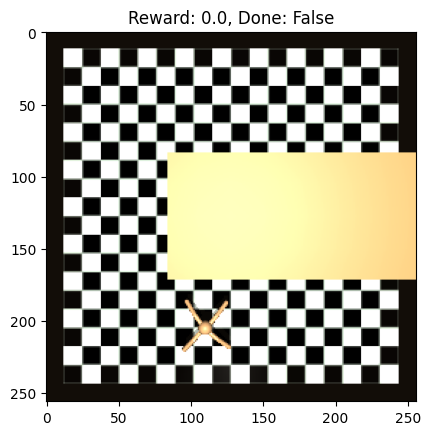

In [39]:

# カスタム迷路を指定
custom_map = [
    [1, 1, 1, 1, 1],
    [1, 0, 0, 0, 1],
    [1, 0, 1, 1, 1],
    [1, 0, 0, 0, 1],
    [1, 1, 1, 1, 1],
]
# 環境を作成
env = AntMazeEnv(maze_map=custom_map, max_episode_steps=1000)

# 環境をリセット
obs = env.reset()

# 1ステップ実行
action = env.action_space.sample()
obs, reward, terminated, truncated, info = env.step(action)

# エピソード終了フラグ
done = terminated or truncated

# 観測画像を表示
import matplotlib.pyplot as plt
plt.imshow(obs["observation"])
plt.title(f"Reward: {reward}, Done: {done}")
plt.show()

# 環境を閉じる
env.close()


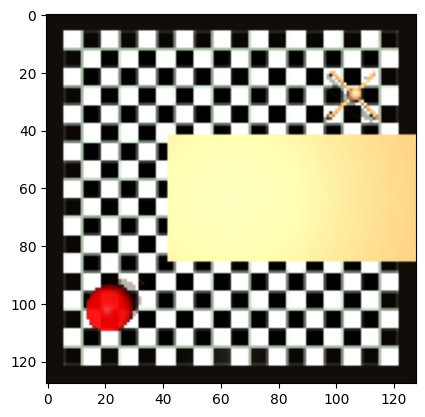

In [24]:


# カスタム迷路を指定
custom_map = [
    [1, 1, 1, 1, 1],
    [1, 0, 0, 0, 1],
    [1, 0, 1, 1, 1],
    [1, 0, 0, 0, 1],
    [1, 1, 1, 1, 1],
]

# custom_map = [
#     [1, 1, 1, 1, 1, 1, 1],
#     [1, 0, 0, 1, 0, 0, 1],
#     [1, 1, 0, 1, 1, 0, 1],
#     [1, 0, 0, 0, 1, 0, 1],
#     [1, 0, 1, 0, 0, 0, 1],
#     [1, 0, 1, 1, 1, 0, 1],
#     [1, 1, 1, 1, 1, 1, 1],
# ]

env = AntMazeEnv(maze_type='UMaze', maze_map=custom_map, max_episode_steps=1000, seed=40)


obs = env.reset()


action = env.action_space.sample()
obs, reward, done, info = env.step(action)

# 画像を確認
import matplotlib.pyplot as plt
plt.imshow(obs)
plt.show()

env.close()


In [ ]:
import sys
from pathlib import Path
from omegaconf import OmegaConf
import numpy as np
import torch
from tqdm import tqdm

import logging

# ログの設定
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[
        logging.StreamHandler(sys.stdout)
    ]
)

logger = logging.getLogger(__name__)

# from config import Config
# from lexa import LEXA
# from envs.franka_kitchen import FrankaKichenEnv
# from replay_buffer import ReplayBuffer
# from utils import fix_seed, preprocess_obs

base_path = "/output"

config_dict = {
    'model': {
        'world_model': {
            'emb_dim': 1024,
            'z_dim': 32,
            'num_classes': 32,
            'h_dim': 600,
            'hidden_dim': 600,
            'num_layers_za2hidden': 1,
            'num_layers_h2z': 1,
            'mlp_hidden_dim': 400,
            'min_std': 0.1,
            'kl_balance_alpha': 0.8,
            'kl_loss_scale': 0.1,
        },
        'explorer': {
            'num_emsembles': 10,
            'emsembles_offset': 1,
            'emsembles_target_mode': 'z',
            'mlp_hidden_dim': 400,
            'min_std': 0.1,
            'discount': 0.99,
            'lambda_': 0.95,
            'actor_entropy_scale': 0.0001,
            'slow_critic_update': 100,
        },
        'achiever': {
            'num_positives': 256,
            'neg_sampling_factor': 0.1,
            'mlp_hidden_dim': 400,
            'min_std': 0.1,
            'discount': 0.99,
            'lambda_': 0.95,
            'actor_entropy_scale': 0.0001,
            'slow_critic_update': 100,
        }
    },
    'env': {
        'task': 'FrankaKitchen-v1',
        'img_size': 128,
        'action_repeat': 2,
        'time_limit': 1000,
    },
    'data': {
        'buffer_size': 200,
        'batch_size': 50,
        'seq_length': 50,
        'imagination_horizon': 15,
    },
    'learning': {
        'seed_steps': 5000,
        'num_steps': 200,
        'expl_episode_freq': 2,
        'world_model_lr': 0.0002,
        'explorer_actor_lr': 0.00004,
        'explorer_critic_lr': 0.0001,
        'achiever_actor_lr': 0.00004,
        'achiever_critic_lr': 0.0001,
        'epsilon': 0.00001,
        'weight_decay': 0.000001,
        'grad_clip': 100,
        'update_freq': 4,
        'eval_episode_freq': 5,
    },
    'wandb': {
        'logging': False,
        'name': 'lexa',
        'group': '',
        'project': 'LEXA',
    },
    'device': 'cuda',
    'seed': 0,
}

def main(cfg):
    logger.info("Initializing configuration and environment...")
    cfg = Config(**cfg)
    fix_seed(cfg.seed)

    # env = FrankaKichenEnv(cfg.env.img_size, cfg.env.action_repeat, cfg.env.time_limit, cfg.seed)
    # eval_env = FrankaKichenEnv(cfg.env.img_size, cfg.env.action_repeat, cfg.env.time_limit, cfg.seed)


    env = AntMazeEnv(maze_type='UMaze', maze_map=custom_map, max_episode_steps=1000, seed=42)
    eval_env = AntMazeEnv(maze_type='UMaze', maze_map=custom_map, max_episode_steps=1000, seed=42)

    logger.info("Environment initialized. Setting up LEXA and replay buffer...")
    lexa = LEXA(cfg, env)
    replay_buffer = ReplayBuffer(cfg.data.buffer_size,
                                 (3, cfg.env.img_size, cfg.env.img_size),
                                 env.action_space.shape[0])

    obs = env.reset()
    logger.info("Starting seed steps...")

    # seed steps
    for step in range(cfg.learning.seed_steps):
        action = env.action_space.sample()
        next_obs, reward, done, info = env.step(action)
        print("Original obs shape:", obs.shape, "dtype:", obs.dtype, "min:", obs.min(), "max:", obs.max())


        # 画像を表示 (必要に応じて一定間隔で表示)

        if step % 1000 == 0:
            plt.figure(figsize=(6, 6))
            plt.imshow(obs)
            plt.title("Original Observation")
            plt.axis("off")
            plt.show()

        replay_buffer.push(preprocess_obs(obs), action, done)
        obs = next_obs
        if done:
            obs = env.reset()
        if step % 1000 == 0:
            logger.info(f"Completed {step} seed steps.")

    logger.info("Seed steps completed. Starting learning steps...")

    # learning steps
    obs = env.reset()
    goal = None
    episodes = 0
    best_score = -1
    for step in tqdm(range(cfg.learning.num_steps)):
        with torch.no_grad():
            if episodes % cfg.learning.expl_episode_freq == 0:
                mode = 'explorer'
            else:
                mode = 'achiever'

            action = lexa.agent(preprocess_obs(obs), mode, goal)
            next_obs, reward, done, info = env.step(action)
            replay_buffer.push(preprocess_obs(obs), action, done)
            obs = next_obs

        if (step + 1) % cfg.learning.update_freq:
            logger.debug("Updating model...")
            observations, actions, done_flags = replay_buffer.sample(cfg.data.batch_size, cfg.data.seq_length)
            metrics = lexa.train(observations, actions)

        if (step + 1) % cfg.model.explorer.slow_critic_update:
            lexa.explorer.update_critic()
        if (step + 1) % cfg.model.achiever.slow_critic_update:
            lexa.achiever.update_critic()

        if done:
            logger.info(f"Steps: {step + 1}, Episode: {episodes}, Metrics: {metrics}")
            lexa.save(base_path / cfg.wandb.name / f'{step + 1}')
            episodes += 1
            obs = env.reset()
            lexa.agent.reset()
            goal, _, _ = replay_buffer.sample(1, 1)
            goal = goal.squeeze(1)
            if episodes % cfg.learning.eval_episode_freq:
                logger.info("Evaluating agent...")
                with torch.no_grad():
                    success = 0
                    for goal_idx in eval_env.goals:
                        eval_obs = eval_env.reset()
                        eval_env.set_goal_idx(goal_idx)
                        goal_obs = eval_env.get_goal_obs()
                        eval_done = False
                        while not eval_done:
                            eval_action = lexa.agent(preprocess_obs(eval_obs), 'achiever', preprocess_obs(goal_obs), train=False)
                            eval_obs, eval_reward, eval_done, eval_info = eval_env.step(eval_action)
                        if eval_env.compute_success():
                            success += 1
                    score = success / len(eval_env.goals)
                logger.info(f"Steps: {step + 1}, Episode: {episodes}, Eval Score: {score}")
                if score > best_score:
                    best_score = score
                    lexa.save(base_path / cfg.wandb.name / 'best')
                lexa.agent.reset()

if __name__ == '__main__':
    logger.info("Starting training script...")
    cfg = OmegaConf.create(config_dict)
    main(cfg)


KeyboardInterrupt: 